<a href="https://colab.research.google.com/github/Haque14/MSE504/blob/main/Midterm_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Midterm MSE 504**

- Instructor: Sergei V. Kalinin
- TA: Sheryl Sanchez, ssanch18@vols.utk.edu

Special instructions:
- please add your name and department
- please share the midterm **both** with instructor and TA

Name: Md Ershadul Haque    
Department: Mechanical, Aerospace, and Biomedical Engineering

# Classification of spectral data

Let's explore and analyze the cathodoluminiscence data from hybrid perovskite solid solutions. Use the ChatGPT to explore how the CL spectra are acquired and what we can learn from them.

In [2]:
!pip install atomai pyroved

In [3]:
from copy import deepcopy as dc

import numpy as np
import torch
import h5py

from scipy import ndimage
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pyroved as pv
import atomai as aoi
import matplotlib.pyplot as plt

# Libraries for data processing and machine learning
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc, adjusted_rand_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
# For image/data manipulation
from scipy.ndimage import zoom

Let's import 4 data sets.

In [4]:
!gdown https://drive.google.com/uc?id=1uCfAKlk5KTnsgNJQiiOsjdsvBx2CMzE1
!gdown https://drive.google.com/uc?id=1TTNNnmIS2b1HW8q7ywLbBRhUUBdTm1KU
!gdown https://drive.google.com/uc?id=195ih426XxtRAlidtxzSA5nIRemP3SvML
!gdown https://drive.google.com/uc?id=1cBfegFNV782WCIEKAn_hDA2RgtAJQkAx

Downloading...
From: https://drive.google.com/uc?id=1uCfAKlk5KTnsgNJQiiOsjdsvBx2CMzE1
To: /content/20220510_D17_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_3g_corrected.h5
100% 49.5M/49.5M [00:00<00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TTNNnmIS2b1HW8q7ywLbBRhUUBdTm1KU
To: /content/0220415_D45_30kx_5kV_32pA_LV_200ms_119X80_40nm_1_corrected.h5
100% 19.8M/19.8M [00:00<00:00, 27.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=195ih426XxtRAlidtxzSA5nIRemP3SvML
To: /content/0220415_D48_30kx_5kV_32pA_LV_400ms_119X80_40nm_2_corrected.h5
100% 19.7M/19.7M [00:00<00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cBfegFNV782WCIEKAn_hDA2RgtAJQkAx
To: /content/0220418_D50_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_8g_re_corrected.h5
100% 15.4M/15.4M [00:00<00:00, 269MB/s]


In [5]:
h5_f1 = h5py.File(r'/content/20220510_D17_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_3g_corrected.h5', 'r+')
h5_f2 = h5py.File(r'/content/0220415_D45_30kx_5kV_32pA_LV_200ms_119X80_40nm_1_corrected.h5', 'r+')
h5_f3 = h5py.File(r'/content/0220415_D48_30kx_5kV_32pA_LV_400ms_119X80_40nm_2_corrected.h5', 'r+')
h5_f4 = h5py.File(r'/content/0220418_D50_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_8g_re_corrected.h5', 'r+')

... and explore their structure. Use ChatGPT to explore what is hdf5 and why it is convenient way to store instrumental data.

In [6]:
print(h5_f4.keys())
print(h5_f4['Acquisition2'].keys())
print(h5_f4['Acquisition2']['ImageData'].keys())

<KeysViewHDF5 ['Acquisition0', 'Acquisition1', 'Acquisition2']>
<KeysViewHDF5 ['ImageData', 'PhysicalData', 'SVIData', 'StateEnumeration']>
<KeysViewHDF5 ['DimensionScaleC', 'DimensionScaleX', 'DimensionScaleY', 'DimensionScaleZ', 'Image', 'PrimaryGlassMediumInterfacePosition', 'SecondaryGlassMediumInterfacePosition', 'TOffset', 'XOffset', 'YOffset', 'ZOffset']>


(1, 1, 1, 960, 1440)


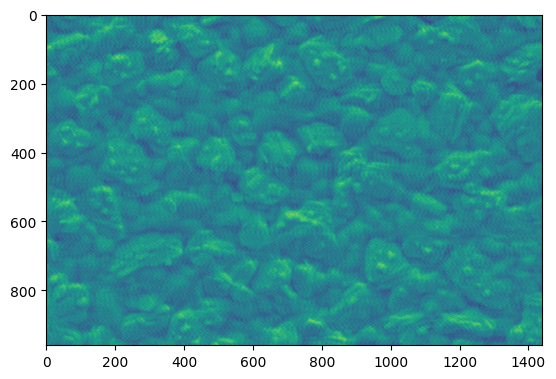

In [7]:
print(h5_f4['Acquisition0']['ImageData']['Image'].shape)
im0 = np.squeeze(h5_f4['Acquisition0']['ImageData']['Image'])
plt.imshow(im0)

(1, 1, 1, 1280, 1904)


(-0.5, 1903.5, 1279.5, -0.5)

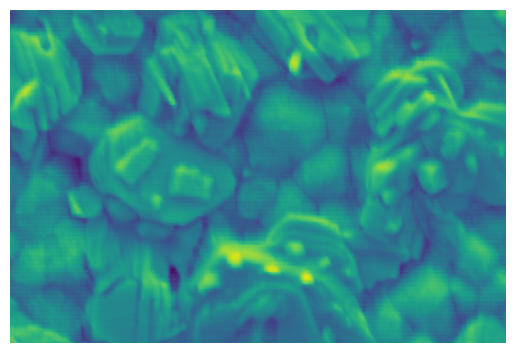

In [8]:
print(h5_f4['Acquisition1']['ImageData']['Image'].shape)
im1 = np.squeeze(h5_f4['Acquisition1']['ImageData']['Image'])
plt.imshow(im1)
plt.axis('off')

(1024, 1, 1, 80, 119)


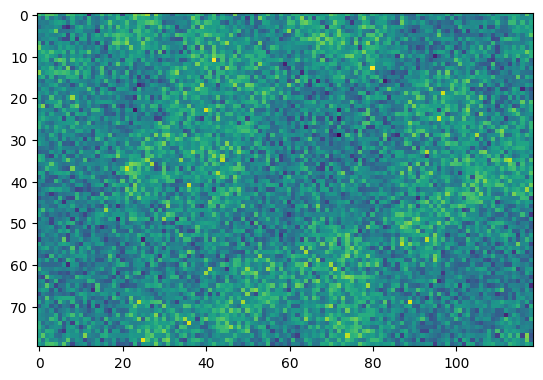

In [9]:
print(h5_f4['Acquisition2']['ImageData']['Image'].shape)
im2 = np.squeeze(h5_f4['Acquisition2']['ImageData']['Image'])
plt.imshow(im2[200,:,:])

In [10]:
dataset = im2.astype(np.float64)
print(dataset.shape)
d1, d2, d3 = dataset.shape
dataset = dataset.reshape(d1, d2*d3)

(1024, 80, 119)


In [11]:
y = torch.from_numpy(np.array(dataset.T))[:, None]
y = torch.nn.functional.avg_pool1d(y, 1, 1).squeeze().numpy()
print(y.shape)
_, s1 = y.shape

(9520, 1024)


In [12]:
y = y.reshape(d2, d3, s1)

In [13]:
hdata = y
hdata = hdata.astype(np.float64)

In [14]:
x=np.linspace(162.17, 1033.31, 1024) #128
wavelength = x

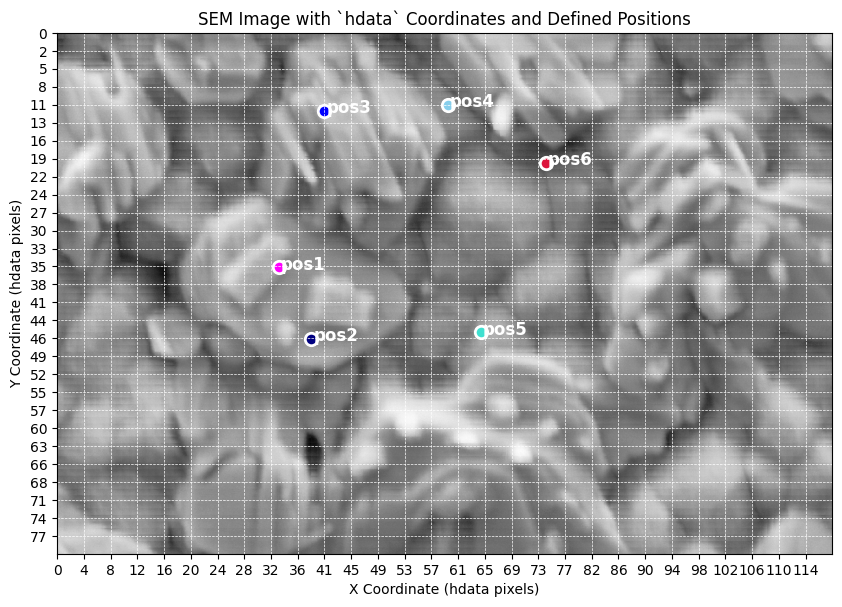

In [15]:
# Assuming im1 is the SEM image and hdata is the CL data
# Extracting dimensions directly from im1 and hdata

sem_shape = im1.shape  # SEM image shape
hdata_shape = hdata.shape  # CL map (hdata) shape

# Calculate the scaling factors based on the dimensions of SEM and hdata
scale_x = sem_shape[1] / hdata_shape[1]  # Scaling factor for width
scale_y = sem_shape[0] / hdata_shape[0]  # Scaling factor for height

# Define positions in hdata coordinates (example coordinates)
positions_hdata = {
    'pos1': [34, 36],  # Example position in hdata coordinates
    'pos2': [39, 47],   # Example position in hdata coordinates
    'pos3': [41, 12],  # Example position in hdata coordinates
    'pos4': [60, 11],  # Example position in hdata coordinates
    'pos5': [65, 46],  # Example position in hdata coordinates
    'pos6': [75, 20],  # Example position in hdata coordinates
}

# Convert hdata coordinates to SEM image coordinates for plotting
positions_sem = {
    key: (pos[0] * scale_x, pos[1] * scale_y)
    for key, pos in positions_hdata.items()
}

# Plot SEM image with grid and `hdata` coordinates on axes
fig, ax = plt.subplots(figsize=(10, 10))

# Display the SEM image
ax.imshow(im1, cmap='Greys_r')

# Adjust the ticks to reflect `hdata` coordinates
xticks = np.linspace(0, sem_shape[1], num=30)  # 30 tick marks across the x-axis
yticks = np.linspace(0, sem_shape[0], num=30)  # 30 tick marks across the y-axis
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels((xticks / scale_x).astype(int))  # Convert to `hdata` coordinates
ax.set_yticklabels((yticks / scale_y).astype(int))  # Convert to `hdata` coordinates

# Add grid and coordinates
ax.grid(True, color='white', linestyle='--', linewidth=0.5)
ax.set_xlabel('X Coordinate (hdata pixels)')
ax.set_ylabel('Y Coordinate (hdata pixels)')

# Plot the converted positions on the SEM image
colors = ['magenta', 'navy', 'blue', 'skyblue', 'turquoise', 'crimson']
for i, (label, pos) in enumerate(positions_sem.items()):
    ax.scatter(*pos, c=colors[i], marker='o', edgecolor='white', linewidth=2, s=80)
    ax.text(pos[0] + 5, pos[1] + 5, f'{label}', color='white', fontsize=12, weight='bold')

ax.set_title('SEM Image with `hdata` Coordinates and Defined Positions')

plt.show()


In [16]:
# Function to find the slice corresponding to a given wavelength
def find_slice_for_wavelength(wavelength_input):
    # Constants
    min_wavelength = 162.17
    max_wavelength = 1033.31
    num_slices = 1024

    # Scaling factor to convert wavelength to slice
    slice_scaling_factor = (max_wavelength - min_wavelength) / (num_slices - 1)

    # Find the slice index
    slice_index = int((wavelength_input - min_wavelength) / slice_scaling_factor)

    # Ensure the slice index is within bounds
    if slice_index < 0 or slice_index >= num_slices:
        return None  # Return None if the wavelength is outside the valid range
    return slice_index

# Example usage: find slice for a given wavelength (e.g., 750 nm)
example_wavelength = 773
slice_for_wavelength = find_slice_for_wavelength(example_wavelength)

slice_for_wavelength

717

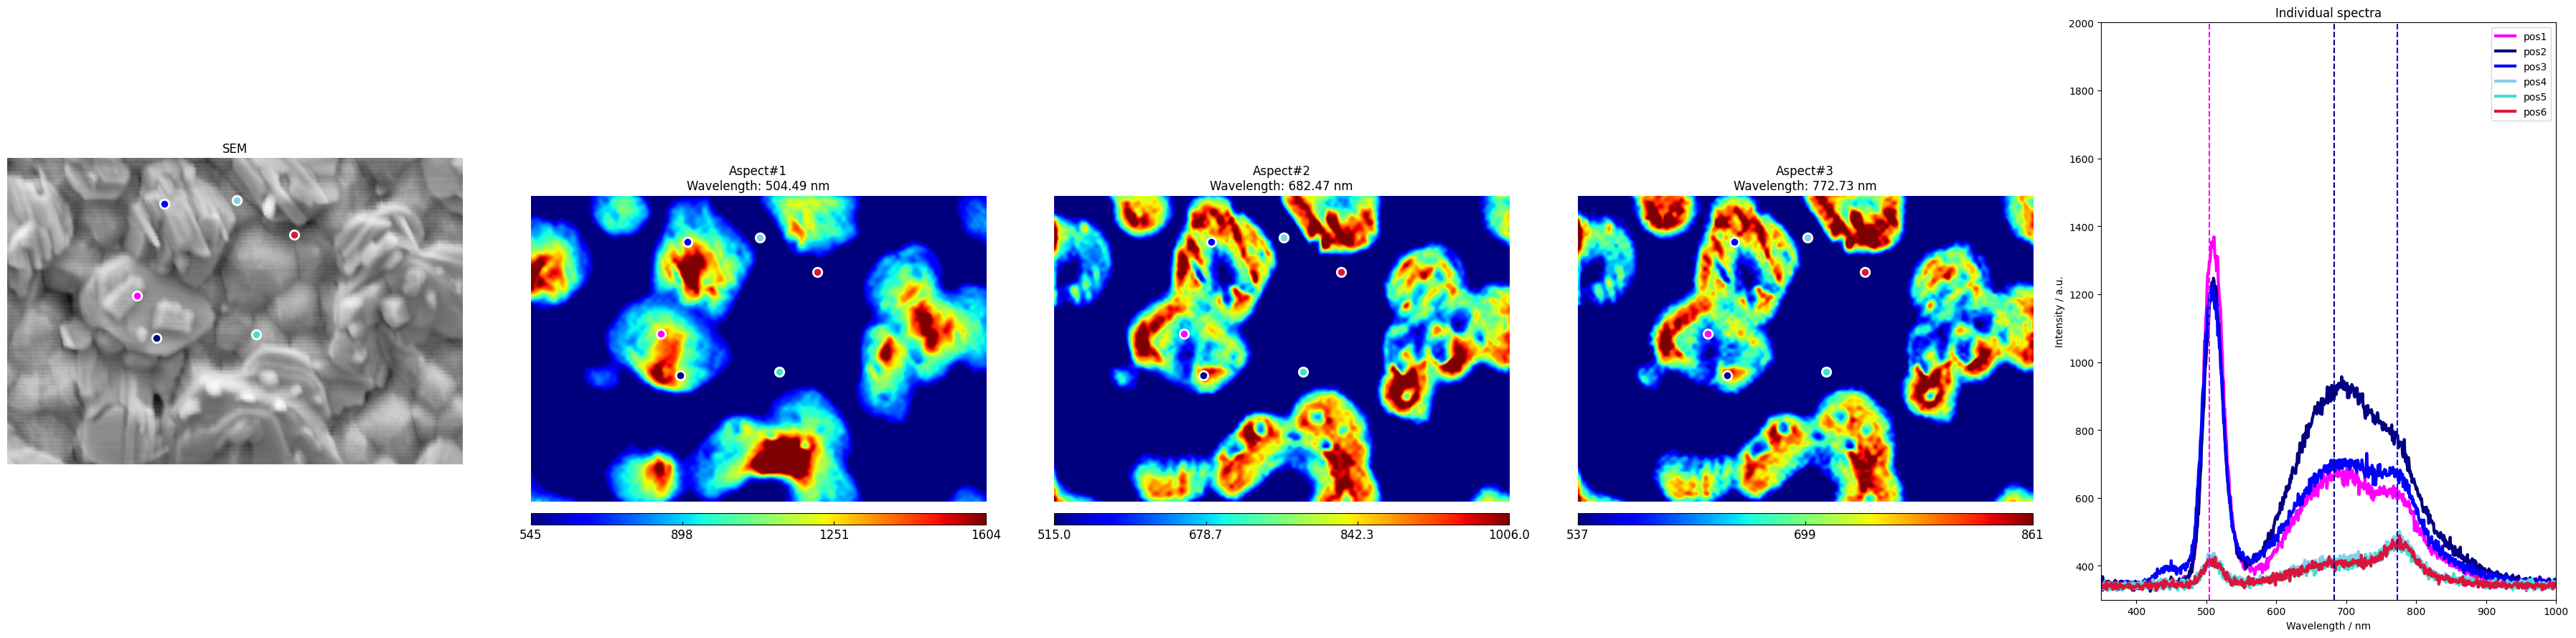

Slice 402 corresponds to wavelength: 504.49 nm
Slice 611 corresponds to wavelength: 682.47 nm
Slice 717 corresponds to wavelength: 772.73 nm


In [17]:
# Assuming positions are adjusted for the SEM image scale
positions = {
  'pos1': [34, 36],  # Example position in hdata coordinates
    'pos2': [39, 47],   # Example position in hdata coordinates
    'pos3': [41, 12],  # Example position in hdata coordinates
    'pos4': [60, 11],  # Example position in hdata coordinates
    'pos5': [65, 46],  # Example position in hdata coordinates
    'pos6': [75, 20],  # Example position in hdata coordinates
}

# Define slices corresponding to different aspects
slices = [402, 611, 717]

# Calculate scaling factors based on SEM and CL map dimensions
scale_x = im1.shape[1] / hdata.shape[1]  # Width scaling factor
scale_y = im1.shape[0] / hdata.shape[0]  # Height scaling factor

# Rescale CL maps to match SEM image dimensions and calculate vmin and vmax automatically
rescaled_cl_maps = []
for s in slices:
    rescaled_map = zoom(hdata[..., s], (scale_y, scale_x))
    vmin = np.floor(np.percentile(rescaled_map, 50))  # Using a higher percentile for vmin, floored to whole number
    vmax = np.ceil(np.percentile(rescaled_map, 98))  # Using a lower percentile for vmax, ceiled to whole number
    rescaled_cl_maps.append((rescaled_map, vmin, vmax))

# Plotting the SEM image and rescaled CL maps with scatter points and scale bars
fig, ax = plt.subplots(1, 5, figsize=(36, 9))  # Adjusted figsize to make CL maps larger and match the scale bars

# Plot SEM image without labeled positions
ax[0].imshow(im1, cmap='Greys_r')
colors = ['magenta', 'navy', 'blue', 'skyblue', 'turquoise', 'crimson']
for i, (label, pos) in enumerate(positions.items()):
    scaled_pos = np.array(pos) * [scale_x, scale_y]
    ax[0].scatter(*scaled_pos, c=colors[i], marker='o', edgecolor='white', linewidth=2, s=80)
ax[0].set_title('SEM')
ax[0].axis('off')

# Define wavelength range
wavelength = np.linspace(162.17, 1033.31, 1024)

# Plot the rescaled CL maps with scatter points and scale bars
for i, (rescaled_map, vmin, vmax) in enumerate(rescaled_cl_maps):
    im = ax[i+1].imshow(rescaled_map, cmap='jet', origin="upper", vmin=vmin, vmax=vmax)
    for pos, color in zip(positions.values(), colors):
        ax[i+1].scatter(pos[0]*scale_x, pos[1]*scale_y, c=color, marker='o', edgecolor='white', linewidth=2, s=80)
    wavelength_value = wavelength[slices[i]]
    ax[i+1].set_title(f'Aspect#{i+1}\nWavelength: {wavelength_value:.2f} nm')
    ax[i+1].axis('off')

    # Adjust the number of ticks for better readability
    num_ticks = 4 if i != 2 else 3  # Reduce the number of ticks for the third aspect
    cbar = plt.colorbar(im, ax=ax[i+1], aspect=40, orientation='horizontal', pad=0.02)
    cbar.set_ticks(np.linspace(vmin, vmax, num_ticks))  # Set ticks as whole numbers and reduce their number
    cbar.ax.tick_params(axis='x', direction='in', labelsize=12)

# Plot the individual spectra with the wavelength range on the last axis
ax[4].clear()  # Ensure no background is plotted
for label, pos, color in zip(positions.keys(), positions.values(), colors):
    ax[4].plot(wavelength, hdata[pos[1], pos[0], :], linewidth=3, c=color, label=label)

# Add vertical lines at the corresponding wavelengths for the slices
for i, s in enumerate(slices):
    ax[4].axvline(x=wavelength[s], linestyle='--', c=colors[i])

ax[4].set_title('Individual spectra')
ax[4].set_xlabel('Wavelength / nm')
ax[4].set_ylabel('Intensity / a.u.')
ax[4].set_xlim(350, 1000)
ax[4].set_ylim(300, 2000)
ax[4].legend(loc='upper right')

plt.tight_layout()
plt.show()

for i, s in enumerate(slices):
    wavelength_s = wavelength[s]
    print(f'Slice {s} corresponds to wavelength: {wavelength_s:.2f} nm')

There are 3 phases present at 505, 683 and 773 nm.
We see some positions have more than one phase present at a time where as some may only have a single peak. Let's try clustering on it.

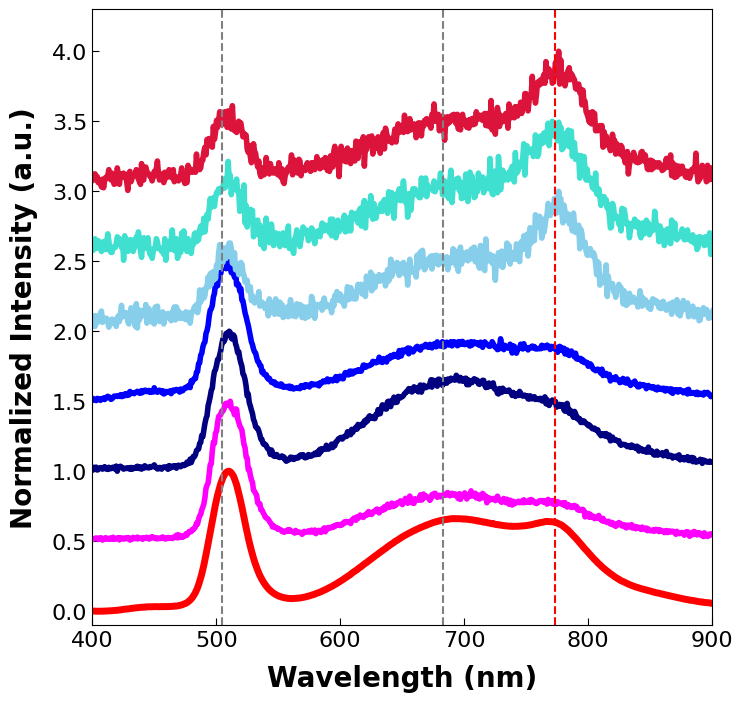

In [18]:
hdata_s = hdata.mean(axis=(0, 1))

normalized_spectra = {}
for label, pos in positions.items():
    spectrum = hdata[pos[1], pos[0], :]
    normalized_spectra[label] = (spectrum - np.min(spectrum)) / (np.max(spectrum) - np.min(spectrum))


plt.figure(figsize=(8, 8))  # Increase figure size for better visibility
plt.plot(wavelength, (hdata_s - np.min(hdata_s)) / (np.max(hdata_s) - np.min(hdata_s)), c='red', linewidth=5, label='Mean Spectrum')


colors = ['magenta', 'navy', 'blue', 'skyblue', 'turquoise', 'crimson']
offset = 0.5  # Increase the offset to avoid overlap

for i, (label, spectrum) in enumerate(normalized_spectra.items()):
    plt.plot(wavelength, spectrum + offset * (i + 1), c=colors[i], linewidth=4, label=label)

plt.axvline(x=505, linestyle='--', c='gray', label='505 nm')
plt.axvline(x=683, linestyle='--', c='gray', label='405 nm')
plt.axvline(x=773, linestyle='--', c='red', label='687 nm')

plt.xlabel('Wavelength (nm)', fontsize=20, labelpad=10, fontweight='bold')
plt.ylabel('Normalized Intensity (a.u.)', fontsize=20, labelpad=10, fontweight='bold')
plt.tick_params(axis='x', length=5, labelsize=16, direction='in')
plt.tick_params(axis='y', length=5, labelsize=16, direction='in')
plt.xlim(400, 900)
plt.ylim(-0.1, offset * (len(positions) + 2) + 0.3)  # Adjust ylim to match the increased offset
#plt.legend(fontsize=12, loc='upper right')

plt.show()

## Manual segmentation for comparison

Let's explore treshold based segmentation. Note that these regions are overlapping, so here one pixel can belong to more then one class.

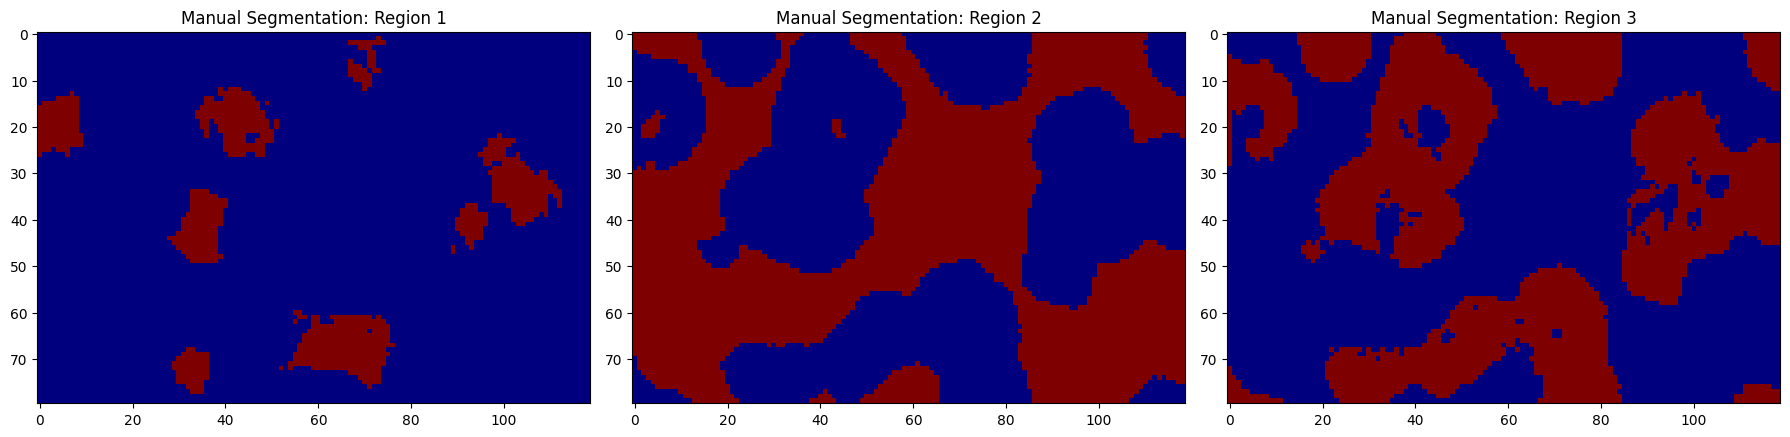

In [19]:
# Assuming slices and hdata are already loaded
s1, s2, s3 = 402, 611, 717

# Extract individual slice data
im_s1 = hdata[..., s1]
im_s2 = hdata[..., s2]
im_s3 = hdata[..., s3]

# Determine thresholds dynamically based on percentile or other criteria
threshold_s1 = np.percentile(im_s1, 90)  # For phase 1
threshold_s2 = np.percentile(im_s2, 50)  # For phase 2
threshold_s3 = np.percentile(im_s3, 60)  # For phase 3

# Apply manual segmentation based on calculated thresholds
im_s1cut = im_s1 > threshold_s1
im_s2cut = im_s2 < threshold_s2
im_s3cut = im_s3 > threshold_s3

# Reshape for visualization
h, w = hdata.shape[:2]
im_s1cut_reshaped = im_s1cut.reshape(h, w)
im_s2cut_reshaped = im_s2cut.reshape(h, w)
im_s3cut_reshaped = im_s3cut.reshape(h, w)

# Plot manual segmentation
_, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(im_s1cut_reshaped, origin="upper", cmap="jet")
ax[0].set_title("Manual Segmentation: Region 1")

ax[1].imshow(im_s2cut_reshaped, origin="upper", cmap="jet")
ax[1].set_title("Manual Segmentation: Region 2")

ax[2].imshow(im_s3cut_reshaped, origin="upper", cmap="jet")
ax[2].set_title("Manual Segmentation: Region 3")

plt.tight_layout()
plt.show()

# Store manual segmentation labels for ground truth (combine regions into one label map)
ground_truth = np.zeros_like(im_s1cut_reshaped, dtype=int)
ground_truth[im_s1cut_reshaped] = 1  # Label for Region 1
ground_truth[im_s2cut_reshaped] = 2  # Label for Region 2
ground_truth[im_s3cut_reshaped] = 3  # Label for Region 3

## Problem 1. Clustering of spectral data

Problem 1a:
- Realize a set of classifiers for the spectral data
- For each classifier, plot the label map and the cluster centroids
- Compare the quality of clustering to the physical segmentation labels above (note that these are not mutually exclusive).


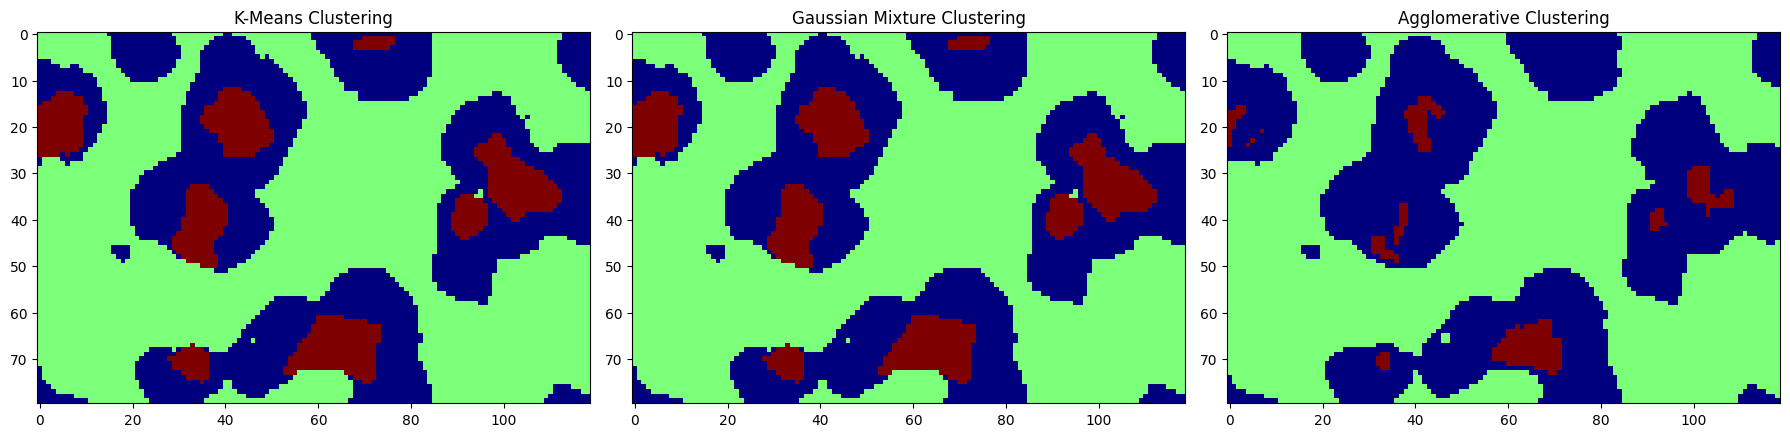

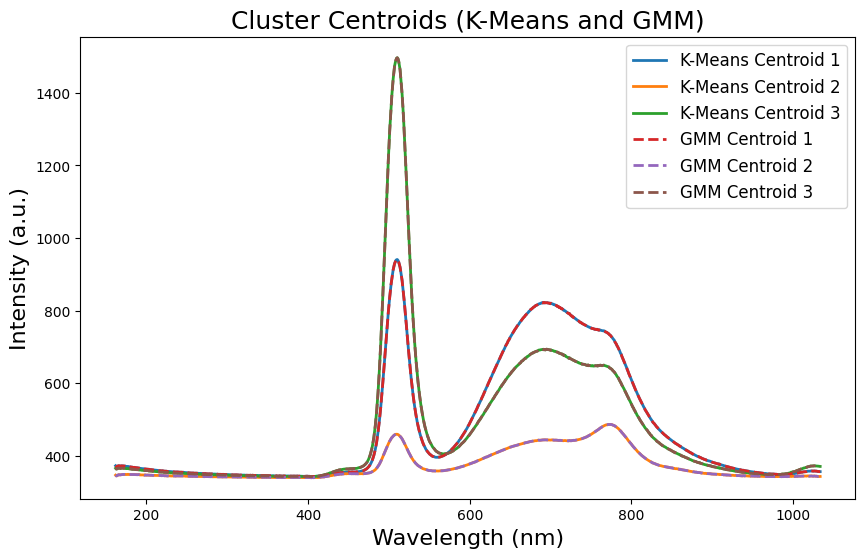

Adjusted Rand Index (K-Means): 0.704
Adjusted Rand Index (GMM): 0.704
Adjusted Rand Index (Agglomerative Clustering): 0.693


In [20]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np

# Assume hdata, ground_truth, and wavelength are defined
h, w, num_spectra = hdata.shape
spectral_data = hdata.reshape(h * w, num_spectra)

# K-Means Clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(spectral_data)
kmeans_label_map = kmeans_labels.reshape(h, w)
kmeans_centroids = kmeans.cluster_centers_

# Gaussian Mixture Clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(spectral_data)
gmm_label_map = gmm_labels.reshape(h, w)
gmm_centroids = gmm.means_

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters)
agglo_labels = agglo.fit_predict(spectral_data)
agglo_label_map = agglo_labels.reshape(h, w)

# Plot clustering label maps
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(kmeans_label_map, cmap='jet', origin='upper')
ax[0].set_title('K-Means Clustering')
ax[1].imshow(gmm_label_map, cmap='jet', origin='upper')
ax[1].set_title('Gaussian Mixture Clustering')
ax[2].imshow(agglo_label_map, cmap='jet', origin='upper')
ax[2].set_title('Agglomerative Clustering')
plt.tight_layout()
plt.show()

# Plot the centroids for K-Means and GMM
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.plot(wavelength, kmeans_centroids[i], label=f'K-Means Centroid {i+1}', linewidth=2)
for i in range(n_clusters):
    plt.plot(wavelength, gmm_centroids[i], label=f'GMM Centroid {i+1}', linestyle='--', linewidth=2)
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Intensity (a.u.)', fontsize=16)
plt.legend(fontsize=12)
plt.title('Cluster Centroids (K-Means and GMM)', fontsize=18)
plt.show()

# Compare clustering with manual segmentation using Adjusted Rand Index
ground_truth_flat = ground_truth.flatten()
ari_kmeans = adjusted_rand_score(ground_truth_flat, kmeans_labels)
ari_gmm = adjusted_rand_score(ground_truth_flat, gmm_labels)
ari_agglo = adjusted_rand_score(ground_truth_flat, agglo_labels)

print(f"Adjusted Rand Index (K-Means): {ari_kmeans:.3f}")
print(f"Adjusted Rand Index (GMM): {ari_gmm:.3f}")
print(f"Adjusted Rand Index (Agglomerative Clustering): {ari_agglo:.3f}")

Problem 1b:
- The cluster labels will be different between different classifiers
- Suggest an approach to compare the classification results between different methods

ARI (KMeans vs GMM): 1.000
ARI (KMeans vs Agglo): 0.844
ARI (GMM vs Agglo): 0.844
NMI (KMeans vs GMM): 1.000
NMI (KMeans vs Agglo): 0.767
NMI (GMM vs Agglo): 0.767


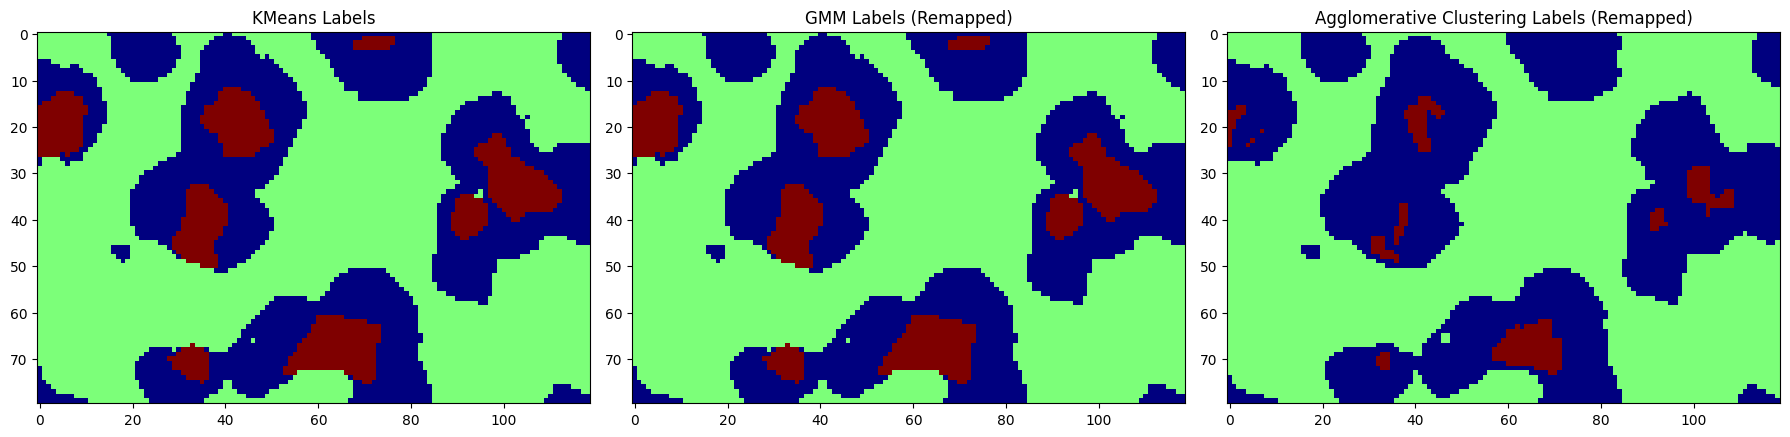

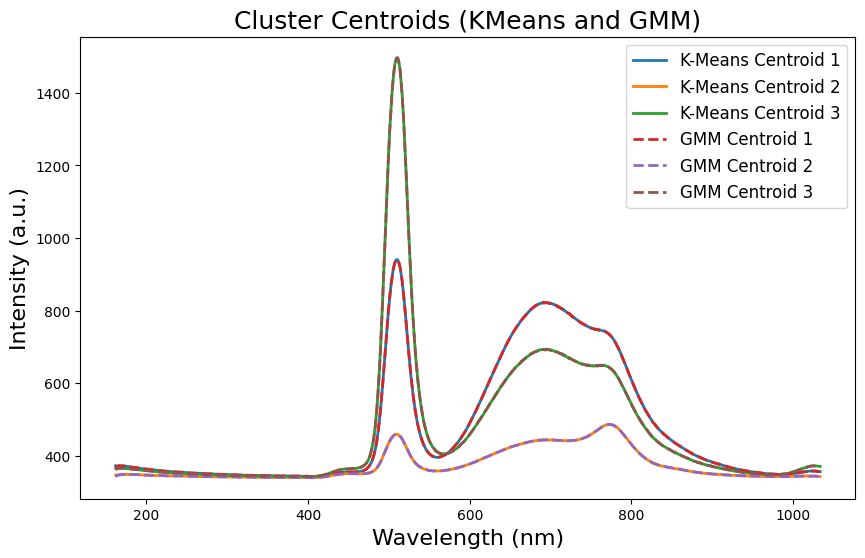

Confusion Matrix (KMeans vs GMM Remapped):
 [[3126    0    0]
 [   0 5432    0]
 [   0    0  962]]
ARI (KMeans vs Ground Truth): 0.704
ARI (GMM vs Ground Truth): 0.704
ARI (Agglomerative Clustering vs Ground Truth): 0.693


In [21]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import numpy as np

# Assuming hdata, ground_truth, and wavelength are defined
# Example setup: hdata is a 3D array of spectral data (height x width x spectra)

# Step 1: Prepare the spectral data for clustering
h, w, num_spectra = hdata.shape
spectral_data = hdata.reshape(h * w, num_spectra)  # Reshape to (pixels, spectra)

# Step 2: Apply Clustering Algorithms

# K-Means Clustering
n_clusters = 3  # Adjust based on the number of expected clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(spectral_data)
kmeans_label_map = kmeans_labels.reshape(h, w)  # Reshape back to image dimensions
kmeans_centroids = kmeans.cluster_centers_

# Gaussian Mixture Clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(spectral_data)
gmm_label_map = gmm_labels.reshape(h, w)
gmm_centroids = gmm.means_

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters)
agglo_labels = agglo.fit_predict(spectral_data)
agglo_label_map = agglo_labels.reshape(h, w)

# Step 3: Compare Clustering Results with ARI and NMI

# Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) do not depend on label matching
ari_kmeans_gmm = adjusted_rand_score(kmeans_labels, gmm_labels)
ari_kmeans_agglo = adjusted_rand_score(kmeans_labels, agglo_labels)
ari_gmm_agglo = adjusted_rand_score(gmm_labels, agglo_labels)

nmi_kmeans_gmm = normalized_mutual_info_score(kmeans_labels, gmm_labels)
nmi_kmeans_agglo = normalized_mutual_info_score(kmeans_labels, agglo_labels)
nmi_gmm_agglo = normalized_mutual_info_score(gmm_labels, agglo_labels)

print(f"ARI (KMeans vs GMM): {ari_kmeans_gmm:.3f}")
print(f"ARI (KMeans vs Agglo): {ari_kmeans_agglo:.3f}")
print(f"ARI (GMM vs Agglo): {ari_gmm_agglo:.3f}")

print(f"NMI (KMeans vs GMM): {nmi_kmeans_gmm:.3f}")
print(f"NMI (KMeans vs Agglo): {nmi_kmeans_agglo:.3f}")
print(f"NMI (GMM vs Agglo): {nmi_gmm_agglo:.3f}")

# Step 4: Remap Cluster Labels using the Hungarian Algorithm (label matching)

def map_labels(true_labels, pred_labels, n_clusters):
    # Create a confusion matrix
    confusion = confusion_matrix(true_labels, pred_labels, labels=range(n_clusters))

    # Use the Hungarian Algorithm to find the best label matching
    row_ind, col_ind = linear_sum_assignment(-confusion)  # Negate to maximize agreement

    # Create new labels based on the optimal assignment
    new_pred_labels = np.copy(pred_labels)
    for i, j in zip(row_ind, col_ind):
        new_pred_labels[pred_labels == j] = i

    return new_pred_labels

# Remap GMM and Agglomerative Clustering labels to match KMeans labels for better comparison
matched_gmm_labels = map_labels(kmeans_labels, gmm_labels, n_clusters)
matched_agglo_labels = map_labels(kmeans_labels, agglo_labels, n_clusters)

# Step 5: Visualize the Label Maps

# Plot KMeans, remapped GMM, and remapped Agglomerative Clustering labels
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(kmeans_label_map, cmap='jet', origin='upper')
ax[0].set_title('KMeans Labels')

ax[1].imshow(matched_gmm_labels.reshape(h, w), cmap='jet', origin='upper')
ax[1].set_title('GMM Labels (Remapped)')

ax[2].imshow(matched_agglo_labels.reshape(h, w), cmap='jet', origin='upper')
ax[2].set_title('Agglomerative Clustering Labels (Remapped)')

plt.tight_layout()
plt.show()

# Step 6: Visualize Cluster Centroids for KMeans and GMM

plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.plot(wavelength, kmeans_centroids[i], label=f'K-Means Centroid {i+1}', linewidth=2)
for i in range(n_clusters):
    plt.plot(wavelength, gmm_centroids[i], label=f'GMM Centroid {i+1}', linestyle='--', linewidth=2)
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Intensity (a.u.)', fontsize=16)
plt.legend(fontsize=12)
plt.title('Cluster Centroids (KMeans and GMM)', fontsize=18)
plt.show()

# Step 7: Confusion Matrix between KMeans and remapped GMM labels
conf_matrix = confusion_matrix(kmeans_labels, matched_gmm_labels)
print("Confusion Matrix (KMeans vs GMM Remapped):\n", conf_matrix)

# Step 8: Compare Clustering with Ground Truth (if available)

# Flatten ground truth segmentation labels for comparison (ground_truth is a 2D array of labels)
ground_truth_flat = ground_truth.flatten()

# Calculate ARI for each clustering result compared to ground truth
ari_kmeans_gt = adjusted_rand_score(ground_truth_flat, kmeans_labels)
ari_gmm_gt = adjusted_rand_score(ground_truth_flat, matched_gmm_labels)
ari_agglo_gt = adjusted_rand_score(ground_truth_flat, matched_agglo_labels)

print(f"ARI (KMeans vs Ground Truth): {ari_kmeans_gt:.3f}")
print(f"ARI (GMM vs Ground Truth): {ari_gmm_gt:.3f}")
print(f"ARI (Agglomerative Clustering vs Ground Truth): {ari_agglo_gt:.3f}")

Problem 1c:
- Explore the dimensionality reduction of the data using the PCA
- Visualize the loading maps and components
- Plot the data in the PCA space and visualize the distribution of the physics based segmentation labels
- Cluster the data in the 2D PCA space
- Compare the resultant labels and the physics based segmentation labels.

Explained Variance by PCA components: [0.84917804 0.1348015 ]


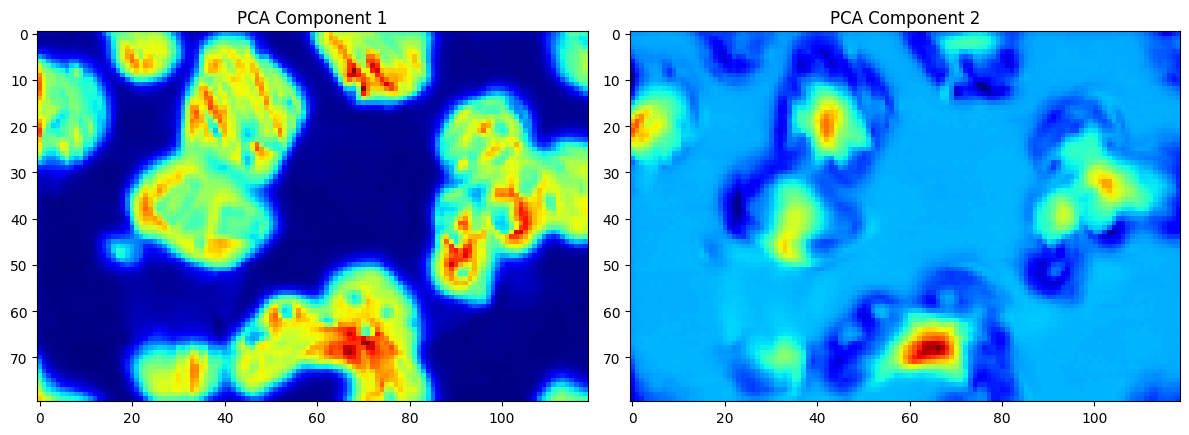

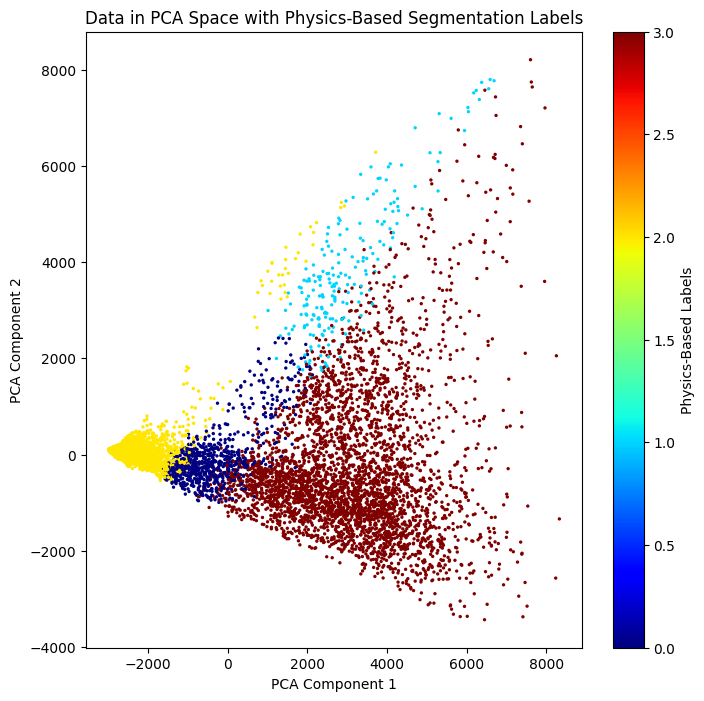

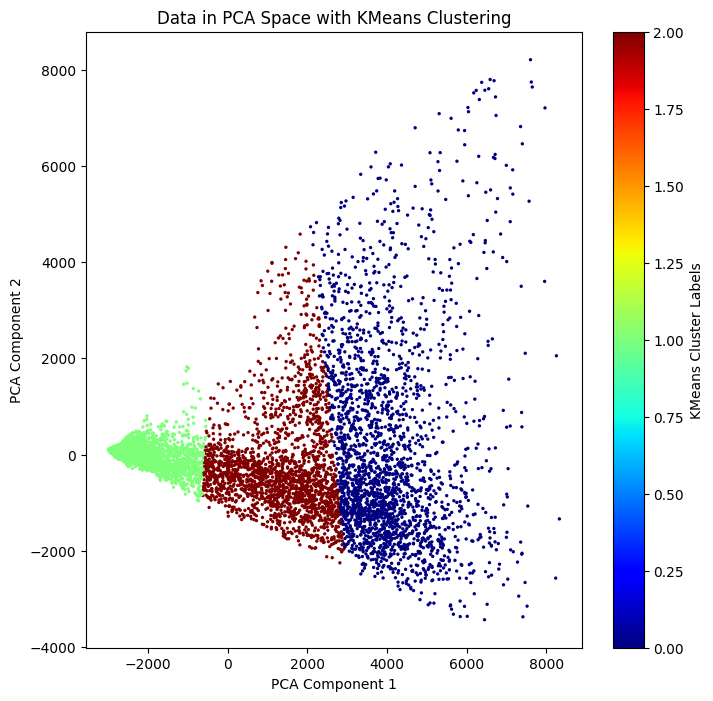

Adjusted Rand Index (ARI) between KMeans and Physics-Based Segmentation: 0.702


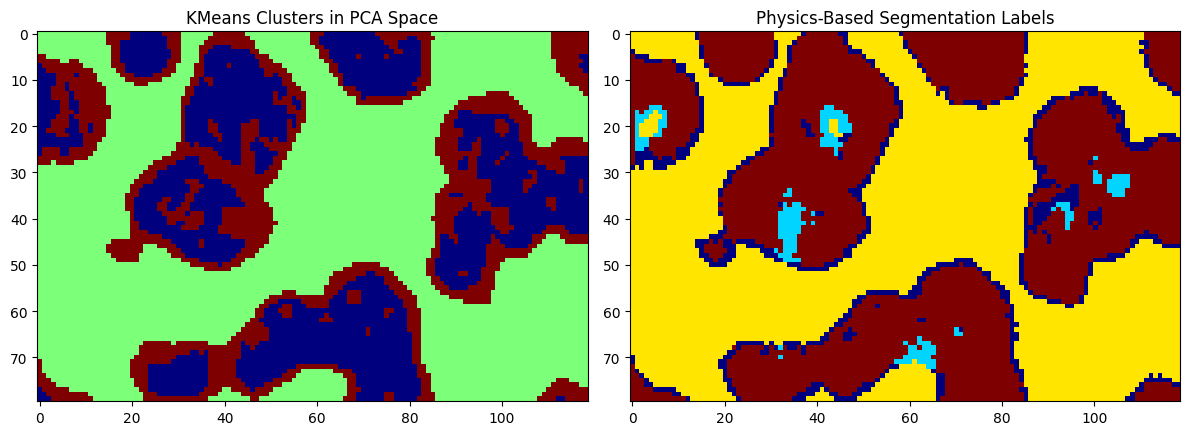

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np

# Assume hdata, ground_truth, and wavelength are defined
h, w, num_spectra = hdata.shape
spectral_data = hdata.reshape(h * w, num_spectra)  # Reshape to (pixels, spectra)

# Step 1: Apply PCA for Dimensionality Reduction

# Perform PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(spectral_data)  # This gives us (pixels, 2)

# Explained variance by each component
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance by PCA components: {explained_variance}')

# Reshape the principal components back to the original spatial dimensions
pca1_map = pca_data[:, 0].reshape(h, w)  # First principal component
pca2_map = pca_data[:, 1].reshape(h, w)  # Second principal component

# Step 2: Visualize the Loading Maps (Principal Components)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(pca1_map, cmap='jet', origin='upper')
ax[0].set_title('PCA Component 1')

ax[1].imshow(pca2_map, cmap='jet', origin='upper')
ax[1].set_title('PCA Component 2')

plt.tight_layout()
plt.show()

# Step 3: Plot the data in PCA space and visualize the distribution of physics-based segmentation labels

# Plot the data points in PCA space
plt.figure(figsize=(8, 8))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=ground_truth.flatten(), cmap='jet', s=2)
plt.title('Data in PCA Space with Physics-Based Segmentation Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Physics-Based Labels')
plt.show()

# Step 4: Cluster the Data in the 2D PCA Space using KMeans

# Apply KMeans clustering in the 2D PCA space
n_clusters = 3  # Adjust based on the number of expected clusters
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(pca_data)

# Plot the data points in PCA space with the KMeans clusters
plt.figure(figsize=(8, 8))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_pca_labels, cmap='jet', s=2)
plt.title('Data in PCA Space with KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='KMeans Cluster Labels')
plt.show()

# Step 5: Compare the resultant labels and physics-based segmentation labels

# Flatten the ground truth segmentation labels
ground_truth_flat = ground_truth.flatten()

# Calculate ARI (Adjusted Rand Index) to compare KMeans clusters with physics-based labels
ari_pca_kmeans = adjusted_rand_score(ground_truth_flat, kmeans_pca_labels)
print(f'Adjusted Rand Index (ARI) between KMeans and Physics-Based Segmentation: {ari_pca_kmeans:.3f}')

# Optional: Visualize KMeans labels and ground truth side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(kmeans_pca_labels.reshape(h, w), cmap='jet', origin='upper')
ax[0].set_title('KMeans Clusters in PCA Space')

ax[1].imshow(ground_truth, cmap='jet', origin='upper')
ax[1].set_title('Physics-Based Segmentation Labels')

plt.tight_layout()
plt.show()

## Problem 2: Supervised learning

Here, we will need to define the class labels. Since we do not have independent access to them, let's use the results of k-means clustering that you have done above as the ground truth labels.

In [23]:
# Assuming 'kmeans_labels' are the clustering labels from KMeans
'''
spectral_labels_reshaped = kmeans_labels.reshape(h, w)  # If you're using KMeans for spectral clustering

# Flatten the CL data (hdata) for supervised learning
h, w, spectra_size = hdata.shape
spectra_all_points = hdata.reshape(-1, spectra_size)

# Flatten the clustering labels for supervised learning
labels_all_points = spectral_labels_reshaped.reshape(-1)
'''

"\nspectral_labels_reshaped = kmeans_labels.reshape(h, w)  # If you're using KMeans for spectral clustering\n\n# Flatten the CL data (hdata) for supervised learning\nh, w, spectra_size = hdata.shape\nspectra_all_points = hdata.reshape(-1, spectra_size)\n\n# Flatten the clustering labels for supervised learning\nlabels_all_points = spectral_labels_reshaped.reshape(-1)\n"

Problem 2a:
- Split the data in the train/test sets, assuming 10% for training and 90% for testing
- Realize the logistic, perceptron, kNN, and SVM classifiers
- Plot the class maps
- Construct the ROC curves

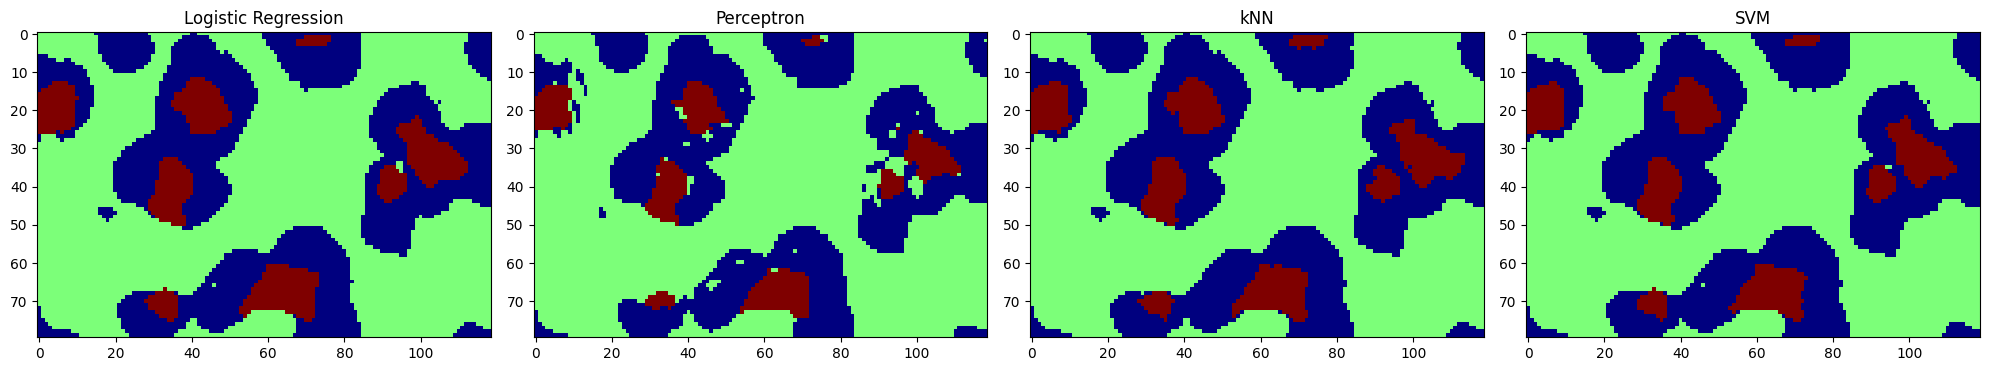

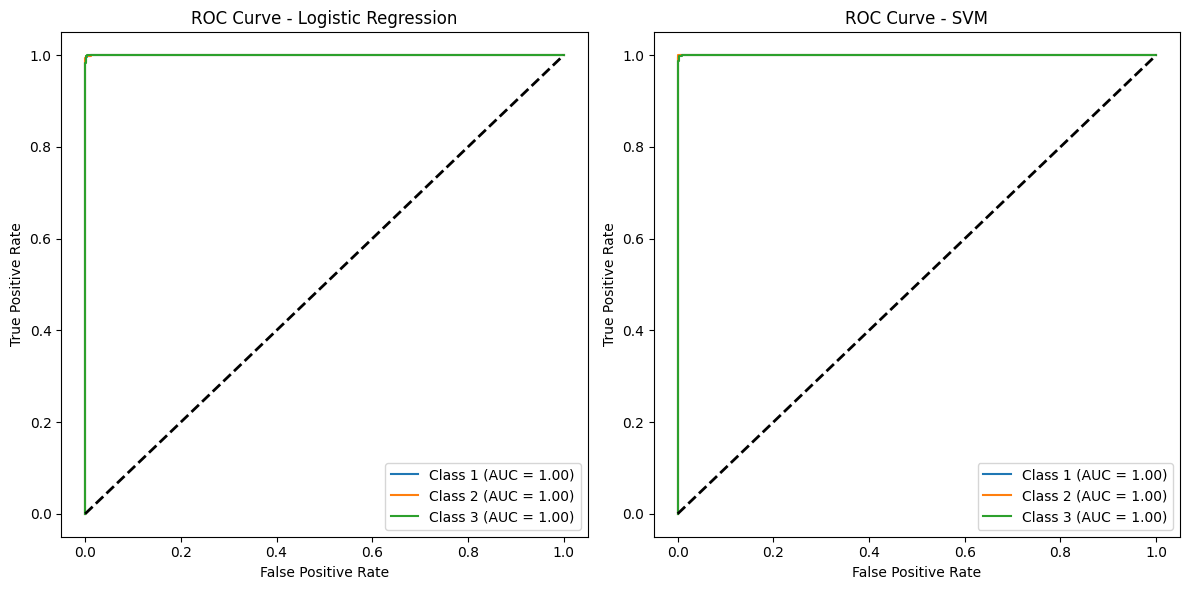

Accuracy of Logistic Regression: 0.996
Accuracy of Perceptron: 0.933
Accuracy of kNN: 0.989
Accuracy of SVM: 0.992


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Split the data into train/test sets (10% for training, 90% for testing)
h, w, spectra_size = hdata.shape
spectra_all_points = hdata.reshape(-1, spectra_size)  # Shape: (h*w, spectra_size)
labels_all_points = kmeans_labels.reshape(-1)  # Flattened clustering labels

# Split data into training (10%) and testing (90%)
X_train, X_test, y_train, y_test = train_test_split(spectra_all_points, labels_all_points, test_size=0.9, random_state=42)

# Step 2: Train classifiers

# Logistic Regression
logistic_clf = LogisticRegression(max_iter=1000)
logistic_clf.fit(X_train, y_train)
y_pred_logistic = logistic_clf.predict(X_test)

# Perceptron Classifier
perceptron_clf = Perceptron(max_iter=1000, random_state=42)
perceptron_clf.fit(X_train, y_train)
y_pred_perceptron = perceptron_clf.predict(X_test)

# k-Nearest Neighbors (kNN)
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

# Support Vector Machine (SVM)
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

# Step 3: Plot the class maps for each classifier

# Reshape predictions to match the image dimensions for visual comparison
h_test, w_test = h, w
logistic_map = logistic_clf.predict(spectra_all_points).reshape(h_test, w_test)
perceptron_map = perceptron_clf.predict(spectra_all_points).reshape(h_test, w_test)
knn_map = knn_clf.predict(spectra_all_points).reshape(h_test, w_test)
svm_map = svm_clf.predict(spectra_all_points).reshape(h_test, w_test)

# Plot the class maps for each classifier
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(logistic_map, cmap='jet', origin='upper')
ax[0].set_title('Logistic Regression')

ax[1].imshow(perceptron_map, cmap='jet', origin='upper')
ax[1].set_title('Perceptron')

ax[2].imshow(knn_map, cmap='jet', origin='upper')
ax[2].set_title('kNN')

ax[3].imshow(svm_map, cmap='jet', origin='upper')
ax[3].set_title('SVM')

plt.tight_layout()
plt.show()

# Step 4: Construct ROC curves

# Get probabilities for ROC curves (SVM with `probability=True` provides probabilities)
y_prob_logistic = logistic_clf.predict_proba(X_test)
y_prob_svm = svm_clf.predict_proba(X_test)

# One-vs-rest ROC for multi-class classification
n_classes = len(np.unique(y_train))
y_test_bin = np.eye(n_classes)[y_test]  # One-hot encode the test labels

# Compute ROC curves for Logistic Regression
fpr_logistic, tpr_logistic, roc_auc_logistic = {}, {}, {}
for i in range(n_classes):
    fpr_logistic[i], tpr_logistic[i], _ = roc_curve(y_test_bin[:, i], y_prob_logistic[:, i])
    roc_auc_logistic[i] = auc(fpr_logistic[i], tpr_logistic[i])

# Compute ROC curves for SVM
fpr_svm, tpr_svm, roc_auc_svm = {}, {}, {}
for i in range(n_classes):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_bin[:, i], y_prob_svm[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Plot ROC curves for both classifiers
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(n_classes):
    ax[0].plot(fpr_logistic[i], tpr_logistic[i], label=f'Class {i+1} (AUC = {roc_auc_logistic[i]:.2f})')
ax[0].plot([0, 1], [0, 1], 'k--', lw=2)
ax[0].set_title('ROC Curve - Logistic Regression')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc='lower right')

for i in range(n_classes):
    ax[1].plot(fpr_svm[i], tpr_svm[i], label=f'Class {i+1} (AUC = {roc_auc_svm[i]:.2f})')
ax[1].plot([0, 1], [0, 1], 'k--', lw=2)
ax[1].set_title('ROC Curve - SVM')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Evaluate accuracy for each classifier (optional)
logistic_acc = accuracy_score(y_test, y_pred_logistic)
perceptron_acc = accuracy_score(y_test, y_pred_perceptron)
knn_acc = accuracy_score(y_test, y_pred_knn)
svm_acc = accuracy_score(y_test, y_pred_svm)

print(f'Accuracy of Logistic Regression: {logistic_acc:.3f}')
print(f'Accuracy of Perceptron: {perceptron_acc:.3f}')
print(f'Accuracy of kNN: {knn_acc:.3f}')
print(f'Accuracy of SVM: {svm_acc:.3f}')

Problem 2b:
- Explore the effect of the decision treshold parameter for the logistic classifier
- Plot class maps for tresholds 0.01, 0.1, 0.5, 0.9, 0.99

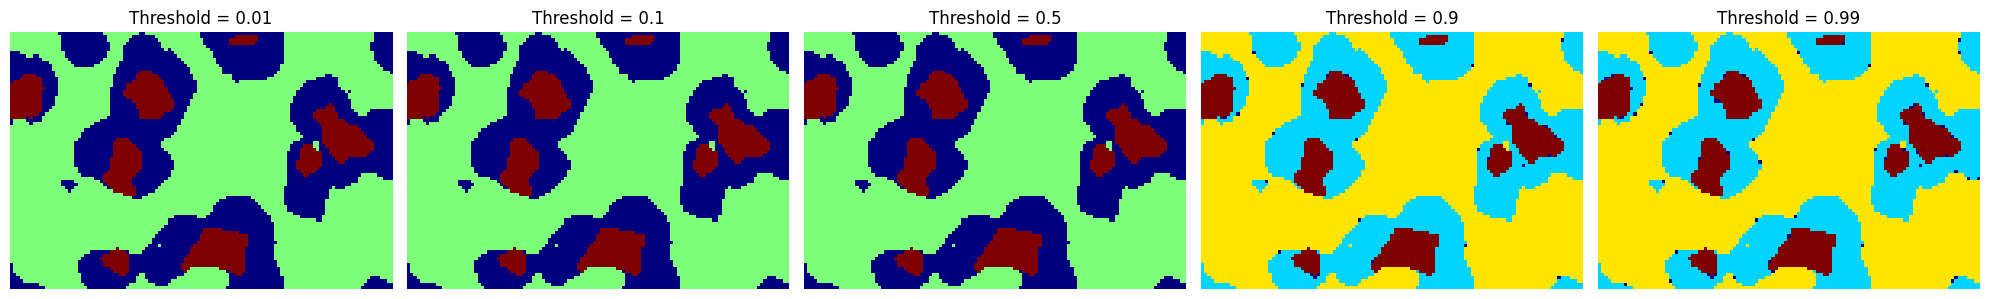

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Split the data (10% training, 90% testing)
h, w, spectra_size = hdata.shape
spectra_all_points = hdata.reshape(-1, spectra_size)  # Shape: (h*w, spectra_size)
labels_all_points = kmeans_labels.reshape(-1)  # Flattened clustering labels

# Split data into training (10%) and testing (90%)
X_train, X_test, y_train, y_test = train_test_split(spectra_all_points, labels_all_points, test_size=0.9, random_state=42)

# Step 2: Train the Logistic Regression classifier
logistic_clf = LogisticRegression(max_iter=1000)
logistic_clf.fit(X_train, y_train)

# Get the probability predictions for the test data
y_prob_logistic = logistic_clf.predict_proba(spectra_all_points)

# Step 3: Define thresholds and compute class predictions for each threshold
thresholds = [0.01, 0.1, 0.5, 0.9, 0.99]
class_maps = {}

# For each threshold, we compute the predicted class based on the highest probability exceeding the threshold
for thresh in thresholds:
    y_pred_thresh = np.zeros_like(y_prob_logistic.argmax(axis=1))  # Initialize predicted labels array
    for i in range(len(y_prob_logistic)):
        if np.max(y_prob_logistic[i]) >= thresh:
            y_pred_thresh[i] = y_prob_logistic[i].argmax()  # Choose the class with the highest probability
        else:
            y_pred_thresh[i] = -1  # Assign a default class for points that don't meet the threshold
    class_maps[thresh] = y_pred_thresh.reshape(h, w)  # Reshape to 2D for visualization

# Step 4: Plot the class maps for each threshold
fig, ax = plt.subplots(1, len(thresholds), figsize=(20, 5))

for i, thresh in enumerate(thresholds):
    ax[i].imshow(class_maps[thresh], cmap='jet', origin='upper')
    ax[i].set_title(f'Threshold = {thresh}')
    ax[i].axis('off')

plt.tight_layout()
plt.show()


Problem 3c:
- Based on the class maps, suggest criteria on how "good" maps can be identified.

Class Distribution at Threshold 0.01: {0: 3124, 1: 5435, 2: 961}


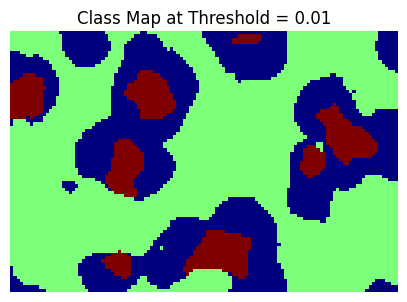

Class Distribution at Threshold 0.1: {0: 3124, 1: 5435, 2: 961}


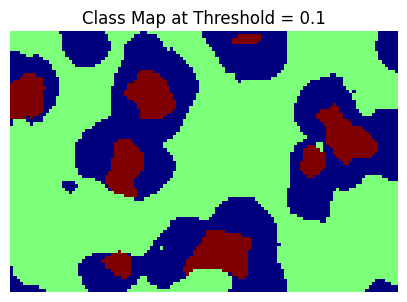

Class Distribution at Threshold 0.5: {0: 3124, 1: 5435, 2: 961}


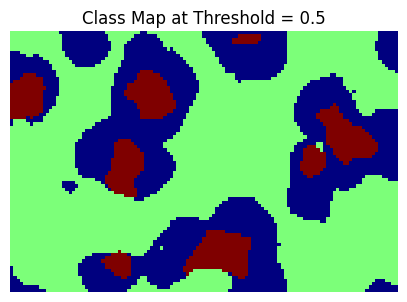

Class Distribution at Threshold 0.9: {-1: 29, 0: 3114, 1: 5423, 2: 954}


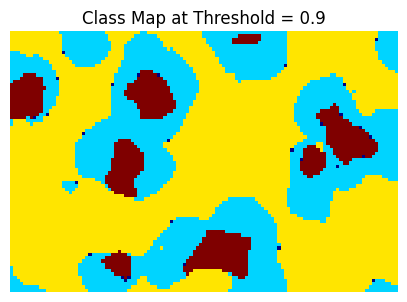

Class Distribution at Threshold 0.99: {-1: 55, 0: 3100, 1: 5418, 2: 947}


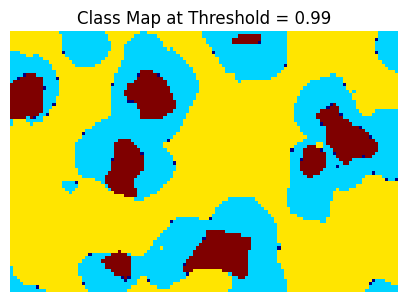

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Assume class_maps is a dictionary of class maps for different thresholds

# Example of how to evaluate class balance and visualize maps
thresholds = [0.01, 0.1, 0.5, 0.9, 0.99]

for thresh in thresholds:
    class_map = class_maps[thresh]

    # Calculate class distribution
    unique, counts = np.unique(class_map, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    print(f"Class Distribution at Threshold {thresh}: {class_distribution}")

    # Plot the class map
    plt.figure(figsize=(5, 5))
    plt.imshow(class_map, cmap='jet', origin='upper')
    plt.title(f'Class Map at Threshold = {thresh}')
    plt.axis('off')
    plt.show()

# Discovering phases and ferroelectric domains

**Lets Install some usefull packages**

In [2]:
# Installing Kornia and pyroved
!pip install -q kornia atomai git+https://github.com/ziatdinovmax/pyroVED@main
!pip install colorspacious
!pip install wget

  Preparing metadata (setup.py) ... done


**Import libraries**

In [3]:
from atomai import utils
from atomai import stat as atomstat
import atomai as aoi

In [4]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

In [6]:
import gdown
import h5py
import wget
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.patches as patches

<span style="color: blue; font-size: 18px;"><strong>Download Dataset</strong></span>

This data set is the collection of high resolution electron microscopy images of the ferroelectric BiFeO3 doped with Sm. The samples were prepared as combinatorial library by Prof. Ichiro Takeuchi group (University of Maryland). The STEM data was taken and physics based analysis was performed by Dr. Chris Nelson (Oak Ridge). Data sharing enables downstream applications and is common in many scientific domains (structural data, thermodynamics, genomics, theoretical computational databases). It is an emerging trend in areas such as microscopy. Note that making data available is a part of FAIR principles and is now mandated by funding agencies in US (NSF, DOE, etc).  

Now, we have access to the SmBFO STEM image with Sm = 0, 7, 10, 13% compositions. Note that Sm = 0 composition is the pure rhombohedral ferroelectric, whereas high Sm concentrations are orthorhombic non-ferroelectric material. Since rhombohedral and orthorhombic phases are crystallograhically incompartible, the phases with intermediate Sm concentrations have to acocmodate this structural mismatch by forming complex nanoscale structures. In macroscopic scattering data, they can show period doubling, low-symmetry phases, etc. - however, their true nanoscale strucutre is understood only poorly. These morphotropic systems also have interesting macroscopic properties such as enhanced dielectric and electromechnical properties. So, let's dive in into atomic world of these systems!

In [7]:
model_files = ['Sm_0_1_HAADF.h5',
               'Sm_0_1_UCParameterization.h5',
               'Sm_7_2_HAADF.h5',
               'Sm_7_2_UCParameterization.h5',
               'Sm_10_1_HAADF.h5',
               'Sm_10_1_UCParameterization.h5',
               'Sm_13_0_HAADF.h5',
               'Sm_13_0_UCParameterization.h5',
               'Sm_20_0_HAADF.h5',
               'Sm_20_0_UCParameterization.h5']

for model_file in model_files:
  print(model_file)
  wget.download("https://zenodo.org/record/4555979/files/"+model_file+"?download=1", out=model_file)

Sm_0_1_HAADF.h5
Sm_0_1_UCParameterization.h5
Sm_7_2_HAADF.h5
Sm_7_2_UCParameterization.h5
Sm_10_1_HAADF.h5
Sm_10_1_UCParameterization.h5
Sm_13_0_HAADF.h5
Sm_13_0_UCParameterization.h5
Sm_20_0_HAADF.h5
Sm_20_0_UCParameterization.h5


In [8]:
#list files
filedir = '/content'
[f for f in os.listdir(filedir)]

['.config',
 'Sm_10_1_HAADF (1).h5',
 'Sm_20_0_HAADF (2).h5',
 'Sm_13_0_HAADF (1).h5',
 'Sm_7_2_UCParameterization (3).h5',
 'Sm_7_2_UCParameterization (1).h5',
 'Sm_7_2_HAADF (3).h5',
 'Sm_0_1_HAADF (3).h5',
 'Sm_7_2_HAADF (1).h5',
 'Sm_13_0_HAADF (2).h5',
 'Sm_10_1_UCParameterization.h5',
 'Sm_20_0_HAADF (1).h5',
 'Sm_10_1_HAADF (3).h5',
 'Sm_10_1_HAADF.h5',
 'Sm_13_0_UCParameterization (2).h5',
 'Sm_7_2_UCParameterization.h5',
 'Sm_13_0_HAADF.h5',
 'Sm_0_1_UCParameterization (3).h5',
 'Sm_10_1_HAADF (2).h5',
 'Sm_20_0_UCParameterization (2).h5',
 'Sm_10_1_UCParameterization (1).h5',
 'Sm_10_1_UCParameterization (3).h5',
 'Sm_0_1_UCParameterization (2).h5',
 'Sm_7_2_HAADF.h5',
 'Sm_20_0_UCParameterization (3).h5',
 'Sm_7_2_HAADF (2).h5',
 'Sm_0_1_UCParameterization (1).h5',
 'Sm_20_0_UCParameterization (1).h5',
 'Sm_20_0_HAADF.h5',
 'Sm_20_0_UCParameterization.h5',
 'Sm_0_1_HAADF (2).h5',
 'Sm_7_2_UCParameterization (2).h5',
 'Sm_10_1_UCParameterization (2).h5',
 'Sm_0_1_HAADF.h5',
 

In [9]:
#image files
composition_tags = [0,7,10,13,20]    #Sm composition %


img_filename = ['Sm_0_1_HAADF.h5',
                'Sm_7_2_HAADF.h5',
                'Sm_10_1_HAADF.h5',
                'Sm_13_0_HAADF.h5',
                'Sm_20_0_HAADF.h5',]

imnum = len(img_filename)

#parametrization files

UCparam_filename = ['Sm_0_1_UCParameterization.h5',
                    'Sm_7_2_UCParameterization.h5',
                    'Sm_10_1_UCParameterization.h5',
                    'Sm_13_0_UCParameterization.h5',
                    'Sm_20_0_UCParameterization.h5',]

#load parameter files
UCparam = []
for x in UCparam_filename:
  print('loading parameterization file: ', os.path.join(filedir, x))
  temp = h5py.File(os.path.join(filedir, x), 'r')
  UCparam.append(temp)

#load images
imgdata = []
for x in img_filename:
  print('loading image file: ', os.path.join(filedir, x))
  temp = h5py.File(os.path.join(filedir, x), 'r')['MainImage']
  imgdata.append(temp)

print('UC parameterization:', [k for k in UCparam[0].keys()])

loading parameterization file:  /content/Sm_0_1_UCParameterization.h5
loading parameterization file:  /content/Sm_7_2_UCParameterization.h5
loading parameterization file:  /content/Sm_10_1_UCParameterization.h5
loading parameterization file:  /content/Sm_13_0_UCParameterization.h5
loading parameterization file:  /content/Sm_20_0_UCParameterization.h5
loading image file:  /content/Sm_0_1_HAADF.h5
loading image file:  /content/Sm_7_2_HAADF.h5
loading image file:  /content/Sm_10_1_HAADF.h5
loading image file:  /content/Sm_13_0_HAADF.h5
loading image file:  /content/Sm_20_0_HAADF.h5
UC parameterization: ['I1', 'I2', 'I3', 'I4', 'I5', 'NCOM', 'PCOM', 'Pxy', 'Vol', 'a', 'ab', 'abdelta', 'alpha', 'atmindex', 'b', 'index', 'meanuca', 'meanucb', 'nbrUC', 'xy_COM', 'xy_atms']


- In addition to the raw STEM data, the parametrization files yield the information on each unit cell within the data that we can use as a physics-based comparison to ML analyses. For example, I1-5 are intensity of atomic columns, Vol is unit cell volume, Pxy are polarization components, and so on.
- Note that since the physics of these systems is not known exactly (that is why we are studying them!), ML can discover new phenomena that were not acocunted for in physics-based descriptors.
- Look though the code below and try to follow how we store and organize the data.  

In [10]:
#function maps x,y grid positions into a matrix data format
def map2grid(inab, inVal):

  default_val = np.nan
  abrng = [int(np.min(inab[:,0])), int(np.max(inab[:,0])), int(np.min(inab[:,1])), int(np.max(inab[:,1]))]
  abind = inab
  abind[:,0] -= abrng[0]
  abind[:,1] -= abrng[2]
  Valgrid = np.empty((abrng[1]-abrng[0]+1,abrng[3]-abrng[2]+1))
  Valgrid[:] = default_val
  Valgrid[abind[:,0].astype(int),abind[:,1].astype(int)]=inVal[:]
  return Valgrid, abrng

In [11]:
def plot_polarization_vectors(k):

    # Prepare vector components and positions
    X = k['ab_x'].ravel()
    Y = k['ab_y'].ravel()
    U = k['ab_Px'].ravel()
    V = k['ab_Py'].ravel()

    # Rotate coordinates 90 degrees counter-clockwise
    X_rot = -Y
    Y_rot = X

    # Invert y-axis
    Y_rot = -Y_rot

    # Rotate vector components
    U_rot = -V
    V_rot = U

    # Invert y-axis component of vectors
    V_rot = -V_rot

    # Compute magnitude and direction of the polarization vectors
    # Compute magnitude and direction of the polarization vectors
    Pmag = np.sqrt(U**2 + V**2)
    Pdir = np.arctan2(V, U)

    # Normalize magnitude for color scaling (clip at 90th percentile to avoid outliers)
    Pmag_norm = np.clip(Pmag / np.nanpercentile(Pmag, 90), 0, 1)

    # Define the colormap for mapping the direction and magnitude
    # Since 'papuc' may not be available, we'll use a built-in colormap

    # Normalize direction to [0, 1] for colormap mapping
    norm = Normalize(vmin=-np.pi, vmax=np.pi)
    cmap = cm.hsv  # Using HSV colormap to represent directions

    # Map direction to colors
    cP = cmap(norm(Pdir))

    # Alternatively, adjust colors based on magnitude if desired
    # For this simple example, we'll just use direction for color
    return Y, X, U, V, cP

In [12]:
SBFOdata = []     #this will be the output list of dictionaries for each dataset

for i in np.arange(imnum):
  temp_dict = {'Index': i}
  temp_dict['Composition'] = composition_tags[i]
  temp_dict['Image'] = imgdata[i]
  temp_dict['Filename'] = img_filename[i]

  for k in UCparam[i].keys():       #add labels for UC parameterization
    temp_dict[k] = UCparam[i][k][()]

  #select values mapped to ab grid
  temp_dict['ab_a'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['ab'][()].T[:,0])[0]       #a array
  temp_dict['ab_b'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['ab'][()].T[:,1])[0]       #b array
  temp_dict['ab_x'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['xy_COM'][()].T[:,0])[0]   #x array
  temp_dict['ab_y'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['xy_COM'][()].T[:,1])[0]   #y array
  temp_dict['ab_Px'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Pxy'][0])[0]             #Px array
  temp_dict['ab_Py'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Pxy'][1])[0]        #Py array
  temp_dict['Vol'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Vol'])[0]     #Vol array

  SBFOdata.append(temp_dict)

Explore the structure of the SBFOdata object. Are the comments in the code sufficient to interpret what are the individual elements in it?

In [13]:
SBFOdata[1].keys()

dict_keys(['Index', 'Composition', 'Image', 'Filename', 'I1', 'I2', 'I3', 'I4', 'I5', 'NCOM', 'PCOM', 'Pxy', 'Vol', 'a', 'ab', 'adelta', 'alpha', 'atmindex', 'b', 'bdelta', 'index', 'meanuca', 'meanucb', 'nbrUC', 'xy_COM', 'xy_atms', 'ab_a', 'ab_b', 'ab_x', 'ab_y', 'ab_Px', 'ab_Py'])

In [14]:
SBFOdata[1]['ab_a'].shape

(166, 155)

Now, let's visualize the images and corresponding distributions of polarization components Px, Py, and unit cell volume Vol

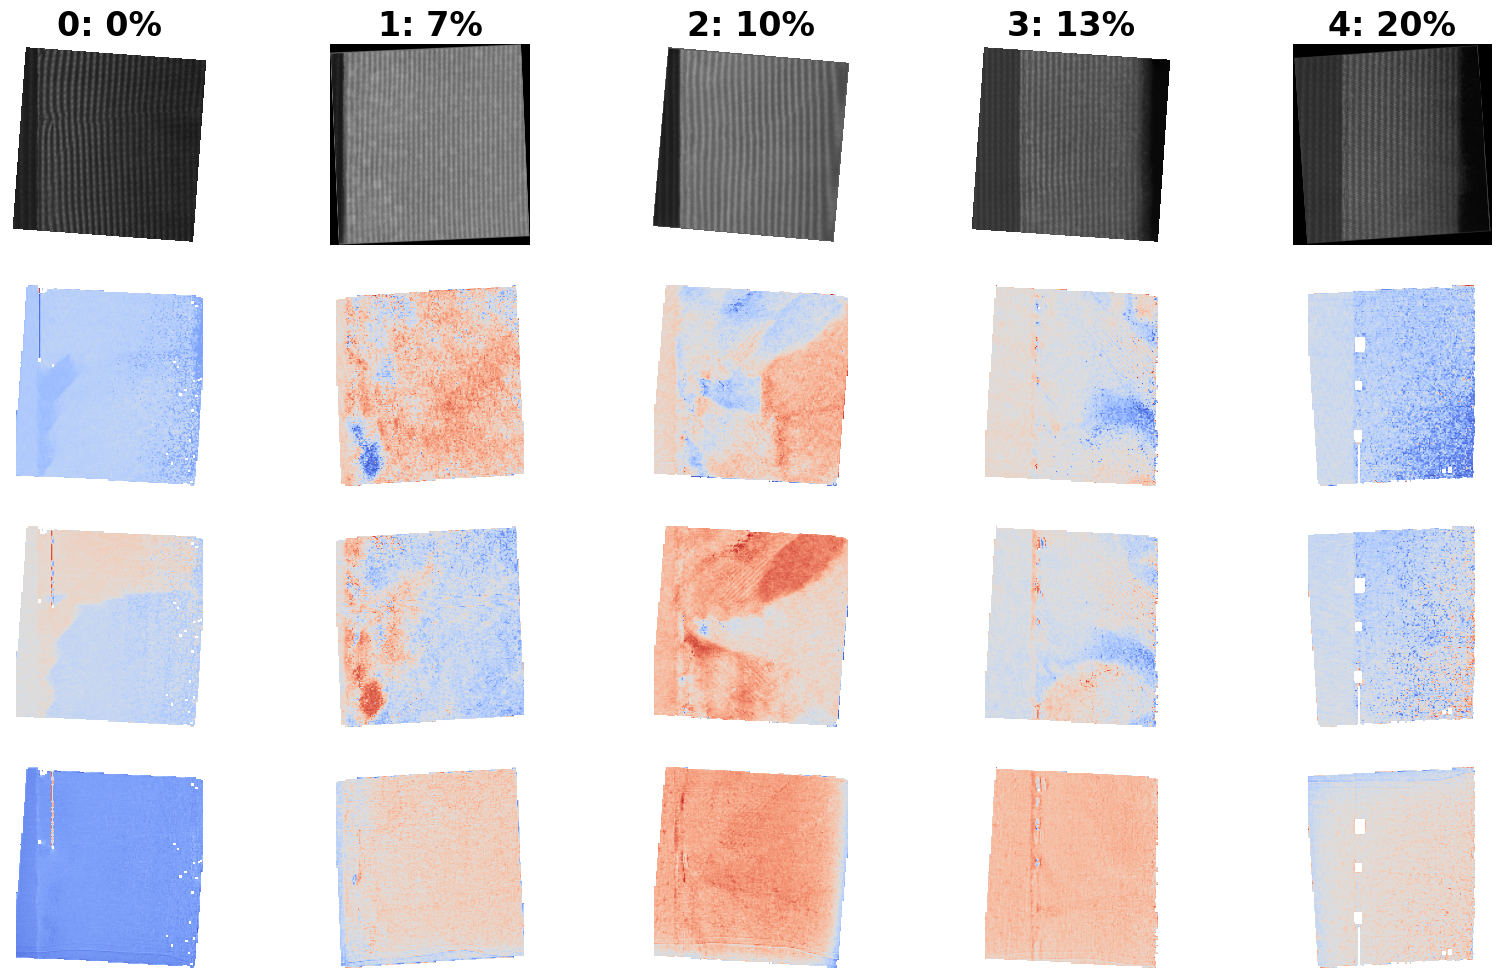

In [15]:
fig, ax = plt.subplots(nrows=4, ncols=len(SBFOdata), figsize=(4*len(SBFOdata), 4*3), dpi=100)
for i, k in enumerate(SBFOdata):
  #Image
  ax[0,i].imshow(k['Image'], origin='upper', cmap='gray')
  ax[0,i].set_title(str(k['Index'])+': '+str(k['Composition'])+'%', fontsize = 24, fontweight = "bold")
  ax[0,i].set_axis_off()
  #Px
  ax[1,i].imshow(k['ab_Px'], origin='upper', cmap='coolwarm')
  ax[1,i].set_axis_off()
  #Py
  ax[2,i].imshow(k['ab_Py'], origin='upper', cmap='coolwarm')
  ax[2,i].set_axis_off()

  # Vol (added row to display Vol)
  ax[3, i].imshow(k['Vol'], origin='upper', cmap='coolwarm')
  ax[3, i].set_axis_off()

As you can see, for low Sm concentrations the olarization maps show clear ordered ferroelectric domains.On increasing Sm concentration, they become more disordered and then disappear for 20% Sm. Also note that unit cell volume map shows (some) variation between material and substrate, does not show variations associated with the domains, and also shows smooth changes across the image plane. The latter are associated with non-ideality of the microscope (the mis-tilt effects).

You can also note the missing regions on the last image. These correspond to the regions that contained growth defects and were removed during the curation of the data set.

## **Problem 3:** Classification of ferroic domains

Now, let's experiment with the practical problem.
- Let's assume that we **know** the phase/ferroic orientation in several regions of the material. These will be our labels.
- Given these labels, we would like to classify the remaining parts of the image.
- However, for the time being we also **do not** have any information about atomic positions, physical order parameter fields, etc. All we have access to is the image data. Can we classify the regions in the image given small amount of known labels?

Let's do it for pure BFO (with well defined domains), corresponding to imgdata[0]. We will use the sliding window approach, representing the image as a collection of image patches of certain size taken from the grid of points. Explore the code below to identify how this is done.


In [16]:
img_array = np.array(imgdata[0])
scaler = preprocessing.StandardScaler().fit(img_array)
scaler.mean_
scaler.scale_
X_scaled = scaler.transform(img_array)

window_size = 10
step_size = 6

# Generate a grid of coordinates based on the step size
coordinates = aoi.utils.get_coord_grid(X_scaled, step_size)

# Extract the coordinates from the first element (assuming it's the desired set)
coords = coordinates[0]

# Extract subimages, centers of mass, and frame numbers based on the generated grid
imstack_grid, com_grid, frames_grid = aoi.utils.extract_subimages(X_scaled, coords, window_size)

# Output the shape of the extracted image stack
print(imstack_grid.shape)
print(com_grid.shape)
print(frames_grid.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


(453744, 10, 10, 1)
(453744, 2)
(453744,)


Below, we
- Create array of the same length as coordinate and patches filled by zeros
- Identify spatial regions that are substrate, domain 1, 2, and 3
- For coordinates that fall within these, we change labels from 0 to 1,2,3 respectively.

With that, we will have coordinate array, patch array, and label array where 1,2,3 are known labels and 0 are unknown labels. And they can experiment with window sizes and all arrays will be recalculated.


In [17]:
# Initialize a label array of zeros
label_array = np.zeros(len(com_grid), dtype=int)

In [18]:
# Define spatial regions (
substrate_region = [3000, 3150, 400, 550]  # Substrate region
domain1_region = [2000, 2150, 1000, 1150]  # Domain 1 region
domain2_region = [3000, 3150, 2000, 2150]  # Domain 2 region
domain3_region = [1000, 1150, 2000, 2150]  # Domain 3 region

In [19]:
# Ensure that com_grid and label_array are of the same size before processing
if len(label_array) != len(com_grid):
    raise ValueError("label_array and com_grid must have the same length!")

# Assign labels based on the coordinates falling within the regions
for i, (x, y) in enumerate(com_grid):
    if substrate_region[0] <= x <= substrate_region[1] and substrate_region[2] <= y <= substrate_region[3]:
        label_array[i] = 1  # Substrate
    elif domain1_region[0] <= x <= domain1_region[1] and domain1_region[2] <= y <= domain1_region[3]:
        label_array[i] = 2  # Domain 1
    elif domain2_region[0] <= x <= domain2_region[1] and domain2_region[2] <= y <= domain2_region[3]:
        label_array[i] = 3  # Domain 2
    elif domain3_region[0] <= x <= domain3_region[1] and domain3_region[2] <= y <= domain3_region[3]:
        label_array[i] = 4  # Domain 3

# Output the label array and its distribution to check the correctness
print("Label array:", label_array)
print("Distribution of labels:", np.unique(label_array, return_counts=True))

# Ensure that label_array, com_grid, and imstack_grid are aligned in size
print("Coordinates shape (com_grid):", com_grid.shape)
print("Image stack shape (imstack_grid):", imstack_grid.shape)
print("Label array shape:", label_array.shape)

Label array: [0 0 0 ... 0 0 0]
Distribution of labels: (array([0, 1, 2, 3, 4]), array([451194,    650,    625,    650,    625]))
Coordinates shape (com_grid): (453744, 2)
Image stack shape (imstack_grid): (453744, 10, 10, 1)
Label array shape: (453744,)


This is our label array. The region 0 are unknown, the regions 1,2,3, and 4 are known labels.

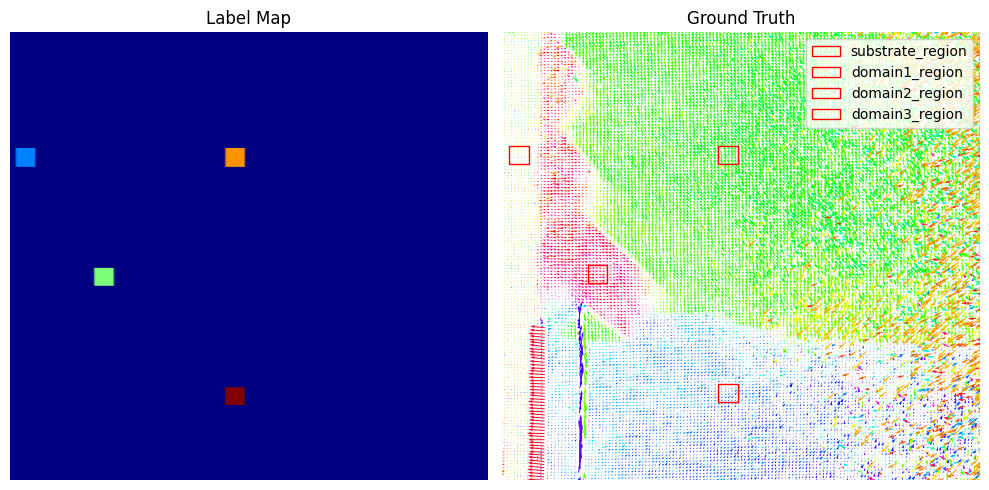

In [20]:
# Example regions to mark on the plot
regions = {
    'substrate_region': (400, 3000, 150, 150),
    'domain1_region': (2000, 1000, 150, 150),
    'domain2_region': (2000, 3000, 150, 150),
    'domain3_region': (1000, 2000, 150, 150)
}

# Assuming 'main' and 'SBFOdata' are defined
main = [350, 4000, 350, 4100]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Visualize the label map on the first subplot
axes[0].scatter(com_grid[:, 1], com_grid[:, 0], c=label_array, cmap='jet', s=10)
axes[0].set_title('Label Map')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
axes[0].invert_yaxis()
axes[0].axis("off")
axes[0].set_xlim(main[0], main[1])
axes[0].set_ylim(main[2], main[3])

# Plot the polarization vectors on the second subplot
k = SBFOdata[0]  # Assuming SBFOdata is well defined with necessary keys
Y, X, U, V, cP = plot_polarization_vectors(k)
axes[1].quiver(Y, X, U, V, color=cP, scale=0.1, angles='xy', scale_units='xy', width=0.002)
axes[1].set_title('Ground Truth')
axes[1].set_xlim(main[0], main[1])
axes[1].set_ylim(main[2], main[3])
axes[1].axis("off")

# Add regions as rectangles on the second subplot
for region_name, (x, y, width, height) in regions.items():
    # Create a rectangle at each region
    rect = Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none', label=region_name)
    axes[1].add_patch(rect)

# Optionally, add a legend if needed
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


In [21]:
# Split the labeled and unlabeled data
labeled_indices = np.where(label_array > 0)[0]  # Indices where labels are known
unlabeled_indices = np.where(label_array == 0)[0]  # Indices where labels are unknown

# Prepare the training data (patches and labels)
X_train = imstack_grid[labeled_indices]  # Known patches (train data)
y_train = label_array[labeled_indices]  # Corresponding labels (1, 2, 3)

# Prepare the test data (patches without labels)
X_test = imstack_grid[unlabeled_indices]  # Patches for unknown labels (test data)
# Check if there are any unknown labels (0s) in the label_array
print(f"Number of unlabeled data points: {np.sum(label_array == 0)}")

# Flatten patches (if needed) for RandomForest input
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten for training
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Flatten for testing

print(f"Number of unlabeled data points: {np.sum(label_array == 1)}")

Number of unlabeled data points: 451194
Number of unlabeled data points: 650


Problem 3a:
- define several classifiers
- classify the unknown points
- make the map of the class labels for each classifier
- create average class labels and uncertainty map based on multiple classifiers.

Problem 3b:
- Choose one classifier
- Explore the effect of the window size on classification

Problem 3c:
- For the regions outside of the labeled ones, we do not have access to the ground truth data (so we can define confusion matrix/ROC/AUC only **within** labeled regions)
- However, we do have access to ground truth data (Px,Py, Vol) and all other descriptors
- Suggest a startegy to estimate the quality of classification if the ground truth labels are not available, but we have access to (Px,Py, Vol). Realize it for one classifier.

Training RandomForest...


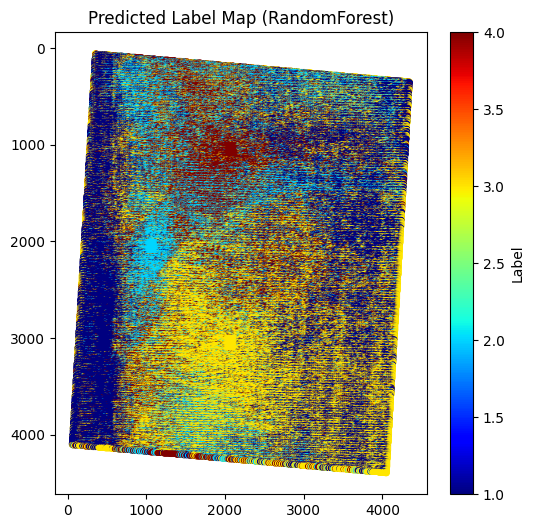

Training SVM...


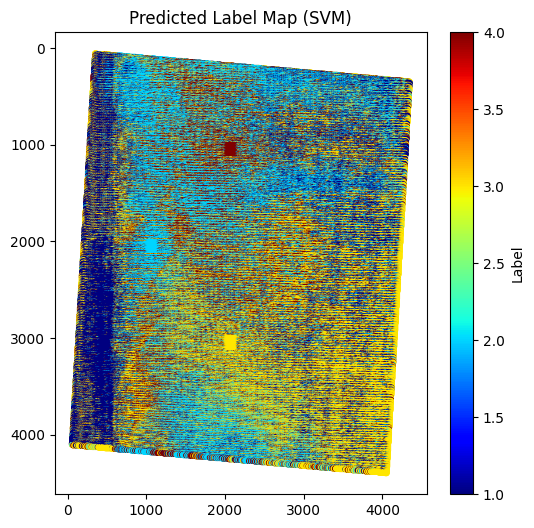

Training KNN...


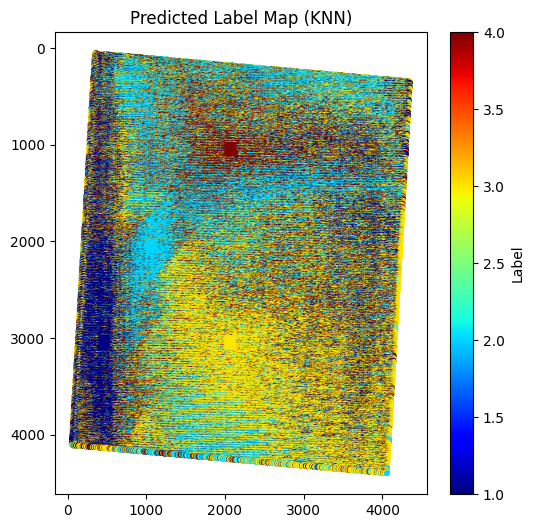

Training LogisticRegression...


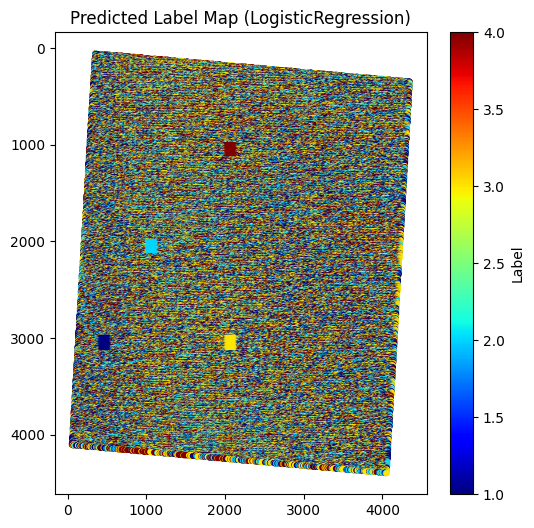

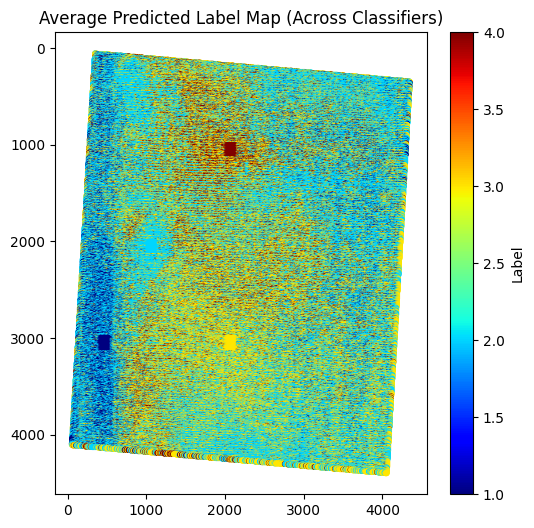

Processing with window size: 30x30


AttributeError: 'list' object has no attribute 'shape'

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#########################################
# Problem 3a: Multiple classifiers, class maps, and uncertainty
#########################################

# Step 1: Define multiple classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

# Dictionary to store predictions
predictions = {}

# Train and classify using multiple classifiers
for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    clf.fit(X_train_flat, y_train)  # Train the classifier on labeled data

    # Predict the labels for the test data (unlabeled patches)
    y_pred = clf.predict(X_test_flat)

    # Store predictions
    predictions[clf_name] = y_pred

    # Assign predicted labels to label_array for unlabeled points
    label_array[unlabeled_indices] = y_pred

    # Ensure that com_grid and label_array match in size
    valid_indices = np.where(label_array > 0)[0]
    com_grid_valid = com_grid[valid_indices]
    label_array_valid = label_array[valid_indices]

    # Visualize predicted label map for each classifier
    plt.figure(figsize=(6, 6))
    plt.scatter(com_grid_valid[:, 1], com_grid_valid[:, 0], c=label_array_valid, cmap='jet', s=10)
    plt.title(f'Predicted Label Map ({clf_name})')
    plt.colorbar(label='Label')
    plt.gca().invert_yaxis()
    plt.show()

# Step 4: Average class labels and uncertainty map

# Convert the predictions to a NumPy array (each row is a classifier's predictions)
pred_matrix = np.array([predictions[clf_name] for clf_name in classifiers])

# Calculate average class labels (majority vote) and uncertainty (variance)
avg_pred = np.round(np.mean(pred_matrix, axis=0)).astype(int)
uncertainty = np.std(pred_matrix, axis=0)

# Assign average predicted labels to the label array
label_array[unlabeled_indices] = avg_pred

# Ensure valid sizes
valid_indices = np.where(label_array > 0)[0]
com_grid_valid = com_grid[valid_indices]
label_array_valid = label_array[valid_indices]

# Visualize average predicted label map
plt.figure(figsize=(6, 6))
plt.scatter(com_grid_valid[:, 1], com_grid_valid[:, 0], c=label_array_valid, cmap='jet', s=10)
plt.title('Average Predicted Label Map (Across Classifiers)')
plt.colorbar(label='Label')
plt.gca().invert_yaxis()
plt.show()

# Visualize uncertainty map
plt.figure(figsize=(6, 6))
plt.scatter(com_grid_valid[:, 1], com_grid_valid[:, 0], c=uncertainty, cmap='hot', s=10)
plt.title('Uncertainty Map (Standard Deviation Across Classifiers)')
plt.colorbar(label='Uncertainty')
plt.gca().invert_yaxis()
plt.show()

#########################################
# Problem 3b: Explore window size effect with RandomForest
#########################################

# Define different window sizes to explore
window_sizes = [(10, 10), (20, 20), (30, 30)]
step_size = 10  # Constant step size

# Store predictions for each window size
predictions_by_window_size = {}

# Function to extract subimages for different window sizes
def custom_subimages(imgdata, step_size, window_size):
    height, width = imgdata.shape[:2]
    x_coords = np.arange(0, height - window_size[0] + 1, step_size)
    y_coords = np.arange(0, width - window_size[1] + 1, step_size)
    coordinates = [(x, y) for x in x_coords for y in y_coords]

    half_height = window_size[0] // 2
    half_width = window_size[1] // 2
    subimages_target = []
    coms_target = []

    for coord in coordinates:
        cx, cy = coord
        top = max(cx - half_height, 0)
        bottom = min(cx + half_height, height)
        left = max(cy - half_width, 0)
        right = min(cy + half_width, width)

        subimage = imgdata[top:bottom, left:right]
        if subimage.shape == tuple(window_size):
            subimages_target.append(subimage)
            coms_target.append(coord)

    return np.array(subimages_target), np.array(coms_target)

# Loop through different window sizes
for window_size in window_sizes:
    print(f"Processing with window size: {window_size[0]}x{window_size[1]}")

    # Extract patches for current window size
    subimages, coms = custom_subimages(imgdata, step_size, window_size)

    # Prepare training and testing data
    X_train = subimages[labeled_indices]
    y_train = label_array[labeled_indices]
    X_test = subimages[unlabeled_indices]

    # Flatten patches for Random Forest
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_flat, y_train)

    # Predict labels for test data
    y_pred = clf.predict(X_test_flat)

    # Store predictions for this window size
    label_array[unlabeled_indices] = y_pred
    predictions_by_window_size[window_size] = np.copy(label_array)

    # Ensure valid sizes
    valid_indices = np.where(label_array > 0)[0]
    com_grid_valid = com_grid[valid_indices]
    label_array_valid = label_array[valid_indices]

    # Visualize predicted label map
    plt.figure(figsize=(6, 6))
    plt.scatter(com_grid_valid[:, 1], com_grid_valid[:, 0], c=label_array_valid, cmap='jet', s=10)
    plt.title(f'Predicted Label Map (Window Size: {window_size[0]}x{window_size[1]})')
    plt.colorbar(label='Label')
    plt.gca().invert_yaxis()
    plt.show()

#########################################
# Problem 3c: Estimate classification quality using Px, Py, and Vol
#########################################

# Extract physical descriptors (Px, Py, Vol) from the dataset
Px = SBFOdata[0]['ab_Px']
Py = SBFOdata[0]['ab_Py']
Vol = SBFOdata[0]['Vol']

# Initialize lists to store descriptors for each class
px_by_class = {1: [], 2: [], 3: [], 4: []}
py_by_class = {1: [], 2: [], 3: [], 4: []}
vol_by_class = {1: [], 2: [], 3: [], 4: []}

# Loop over all patches and store descriptors based on predicted label
for i, label in enumerate(label_array):
    if label > 0:  # Only consider labeled or predicted patches
        x, y = int(com_grid[i, 0]), int(com_grid[i, 1])
        px_by_class[label].append(Px[x, y])
        py_by_class[label].append(Py[x, y])
        vol_by_class[label].append(Vol[x, y])

# Function to calculate mean and variance for descriptors
def descriptor_stats(descriptor_by_class, descriptor_name):
    for class_label in descriptor_by_class:
        values = descriptor_by_class[class_label]
        mean_value = np.mean(values)
        variance_value = np.var(values)
        print(f"Class {class_label} - {descriptor_name}: Mean = {mean_value:.2f}, Variance = {variance_value:.2f}")

# Print statistics for Px, Py, and Vol
print("Homogeneity of Physical Descriptors within Predicted Classes:")
descriptor_stats(px_by_class, "Px")
descriptor_stats(py_by_class, "Py")
descriptor_stats(vol_by_class, "Vol")

# Visualize variance of Px, Py, and Vol within each predicted class
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Px
axes[0].boxplot([px_by_class[1], px_by_class[2], px_by_class[3], px_by_class[4]], labels=[1, 2, 3, 4])
axes[0].set_title('Px Distribution Across Classes')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Px')

# Plot Py
axes[1].boxplot([py_by_class[1], py_by_class[2], py_by_class[3], py_by_class[4]], labels=[1, 2, 3, 4])
axes[1].set_title('Py Distribution Across Classes')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Py')

# Plot Vol
axes[2].boxplot([vol_by_class[1], vol_by_class[2], vol_by_class[3], vol_by_class[4]], labels=[1, 2, 3, 4])
axes[2].set_title('Volume Distribution Across Classes')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Unit Cell Volume')

plt.tight_layout()
plt.show()

## **Problem 4:** Unsupervised exploration

Now, let's explore one of the intermediate concentrations of Sm images using sliding window approach. Let's proceed as following:
- Import one of the images for the intermediate concentrations that show the presence of ferroelectric and ordered phases. Choose an image!
- Create a standard data sets, meaning coordinate array and matching array of patches. Here we add additional degree of freedom by allowing the window to be rectangular, (w1,w2).
- Let's  explore clustering given the patches, and explore window size effects

Custom function for chosing rectangular windows

In [27]:
def custom_subimages(imgdata, step_size, window_size):
    # Generate coordinates based on step size
    height, width = imgdata.shape[:2]
    x_coords = np.arange(0, height - window_size[0] + 1, step_size)
    y_coords = np.arange(0, width - window_size[1] + 1, step_size)
    coordinates = [(x, y) for x in x_coords for y in y_coords]

    # Extract subimages of the specified window size
    half_height = window_size[0] // 2
    half_width = window_size[1] // 2
    subimages_target = []
    coms_target = []
    removed_due_to_size = 0
    removed_due_to_nans = 0

    for coord in coordinates:
        cx, cy = coord
        top = max(cx - half_height, 0)
        bottom = min(cx + half_height, height)
        left = max(cy - half_width, 0)
        right = min(cy + half_width, width)

        subimage = imgdata[top:bottom, left:right]

        if subimage.shape != tuple(window_size):
            removed_due_to_size += 1
        elif np.isnan(subimage).any():
            removed_due_to_nans += 1
        else:
            subimages_target.append(subimage)
            coms_target.append(coord)

    print("Number of subimages removed due to size mismatch:", removed_due_to_size)
    print("Number of subimages removed due to NaNs:", removed_due_to_nans)

    return np.array(subimages_target), np.array(coms_target)

In [28]:
window_size = (12, 20)
step_size = 12

imstack_grid, com_grid = custom_subimages(imgdata[0], step_size, window_size)

print(imstack_grid.shape)
print(com_grid.shape)

Number of subimages removed due to size mismatch: 736
Number of subimages removed due to NaNs: 21977
(113073, 12, 20)
(113073, 2)


Problem 4a:
- Select image and window size
- Cluster the image patches
- Visualize the labels map
- Estimate the required number of clusters


Problem 4b:
- Let's assume that we want to compare multiple clustering approaches. The problem is that cluster labels are assigned randomly, meaning (0,1,2) in one lcustering method will not match the labels from other method
- Suggest and realize approach to align the labels between different clustering methods

Problem 4c:
- Realize 3 different clustering methods of the data
- Align the labels
- Plot the average and uncertainty maps

Number of subimages removed due to size mismatch: 0
Number of subimages removed due to NaNs: 22575


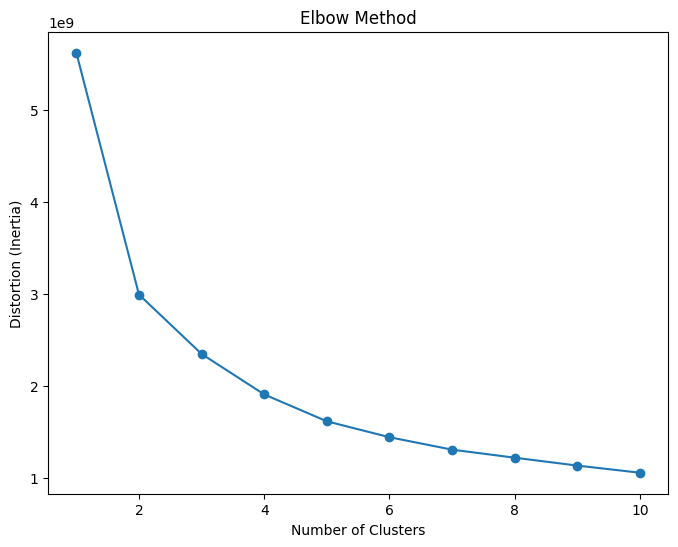

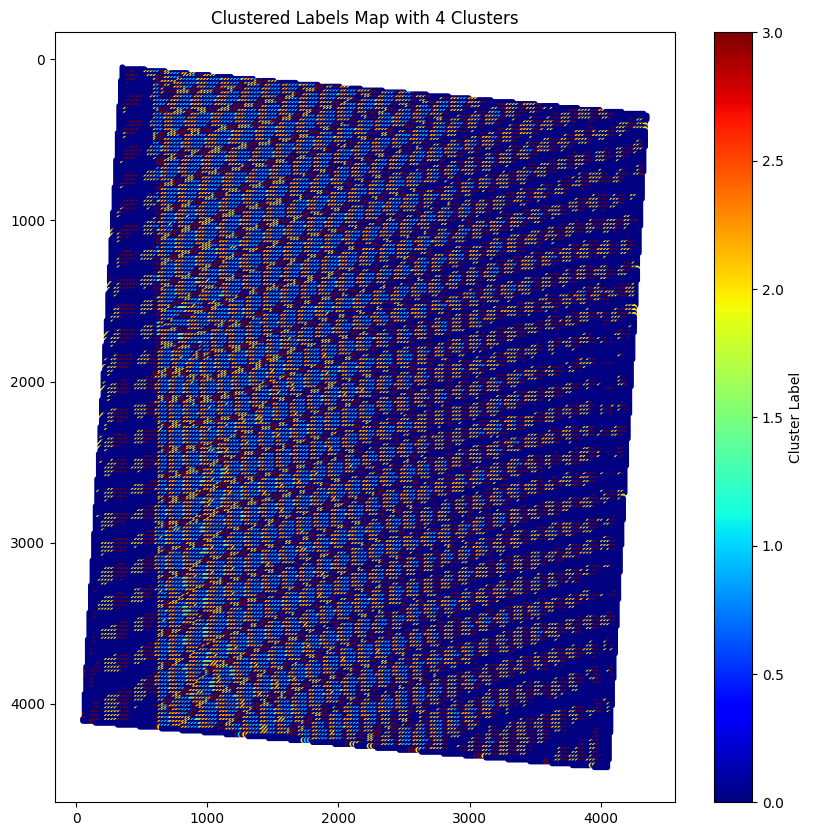

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from skimage.util import view_as_windows
from sklearn.metrics import silhouette_score

# Function to extract rectangular patches using sliding window
def custom_subimages(imgdata, step_size, window_size, pad=False):
    height, width = imgdata.shape[:2]

    # Padding option for boundary handling
    if pad:
        padding = ((window_size[0] // 2, window_size[0] // 2), (window_size[1] // 2, window_size[1] // 2))
        imgdata = np.pad(imgdata, padding, mode='constant', constant_values=np.nan)
        height, width = imgdata.shape[:2]

    x_coords = np.arange(0, height - window_size[0] + 1, step_size)
    y_coords = np.arange(0, width - window_size[1] + 1, step_size)
    coordinates = [(x, y) for x in x_coords for y in y_coords]

    subimages_target = []
    coms_target = []
    removed_due_to_size = 0
    removed_due_to_nans = 0

    for coord in coordinates:
        cx, cy = coord
        top = cx
        bottom = top + window_size[0]
        left = cy
        right = left + window_size[1]

        subimage = imgdata[top:bottom, left:right]

        if subimage.shape != tuple(window_size):
            removed_due_to_size += 1
        elif np.isnan(subimage).any():
            removed_due_to_nans += 1
        else:
            subimages_target.append(subimage)
            coms_target.append([cx + window_size[0] // 2, cy + window_size[1] // 2])  # Store center coordinates

    print("Number of subimages removed due to size mismatch:", removed_due_to_size)
    print("Number of subimages removed due to NaNs:", removed_due_to_nans)

    return np.array(subimages_target), np.array(coms_target), removed_due_to_size, removed_due_to_nans

#########################################
# Problem 4a: Select Image, Cluster Image Patches, and Visualize Labels Map
#########################################

# Function to cluster image patches
def cluster_image_patches(patches, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(patches)
    return labels, kmeans

# Step 1: Select image and define window size
image = imgdata[0]  # Select an image from the dataset (replace with the actual dataset)
window_size = (5, 10)  # Define window size
step_size = 12  # Step size for the sliding window

# Step 2: Extract patches from the image using custom_subimages
imstack_grid, com_grid, removed_size, removed_nans = custom_subimages(image, step_size, window_size)

# Flatten the patches for clustering
n_samples = imstack_grid.shape[0]
patch_size = imstack_grid.shape[1] * imstack_grid.shape[2]
X_patches = imstack_grid.reshape(n_samples, patch_size)

# Step 3: Use the Elbow Method to estimate the number of clusters
def elbow_method(X_patches, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X_patches)
        distortions.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion (Inertia)')
    plt.show()

# Estimate the number of clusters using the elbow method
elbow_method(X_patches, max_clusters=10)

# Step 4: Cluster the image patches
n_clusters = 4  # Set the number of clusters based on the elbow method
labels, kmeans = cluster_image_patches(X_patches, n_clusters)

# Step 5: Visualize the cluster labels map
plt.figure(figsize=(10, 10))
plt.scatter(com_grid[:, 1], com_grid[:, 0], c=labels, cmap='jet', s=10)
plt.title(f'Clustered Labels Map with {n_clusters} Clusters')
plt.colorbar(label='Cluster Label')
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
plt.show()

#########################################
# Problem 4b: Align Cluster Labels Between Different Clustering Methods
#########################################

# Function to align labels using the Hungarian Algorithm
def align_labels(true_labels, predicted_labels):
    # Create a confusion matrix between the two sets of labels
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Use the Hungarian Algorithm to find the optimal label alignment
    row_indices, col_indices = linear_sum_assignment(-confusion)

    # Create a dictionary to map old labels to new aligned labels
    label_map = {old_label: new_label for old_label, new_label in zip(col_indices, row_indices)}

    # Apply the label map to the predicted labels
    aligned_labels = np.array([label_map[label] for label in predicted_labels])

    return aligned_labels

#########################################
# Problem 4c: Apply 3 Clustering Methods, Align Labels, Plot Average and Uncertainty Maps
#########################################

# Step 1: Define different clustering methods
def apply_clustering_methods(X_patches, n_clusters):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_patches)

    # Apply Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg_clustering.fit_predict(X_patches)

    # Apply DBSCAN clustering (with an estimated epsilon)
    dbscan = DBSCAN(eps=5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_patches)

    return kmeans_labels, agg_labels, dbscan_labels

# Apply clustering methods
kmeans_labels, agg_labels, dbscan_labels = apply_clustering_methods(X_patches, n_clusters)

# Step 2: Align the labels using the Hungarian Algorithm
aligned_kmeans = kmeans_labels
aligned_agg = align_labels(kmeans_labels, agg_labels)
aligned_dbscan = align_labels(kmeans_labels, dbscan_labels)

# Step 3: Create average label map and uncertainty map
# Stack the aligned labels
stacked_labels = np.vstack([aligned_kmeans, aligned_agg, aligned_dbscan])

# Compute average label for each point
average_labels = np.round(np.mean(stacked_labels, axis=0)).astype(int)

# Compute uncertainty as the standard deviation across the clustering methods
uncertainty_map = np.std(stacked_labels, axis=0)

# Step 4: Visualize the average label map
plt.figure(figsize=(10, 10))
plt.scatter(com_grid[:, 1], com_grid[:, 0], c=average_labels, cmap='jet', s=10)
plt.title('Average Cluster Labels Map')
plt.colorbar(label='Average Label')
plt.gca().invert_yaxis()
plt.show()

# Step 5: Visualize the uncertainty map
plt.figure(figsize=(10, 10))
plt.scatter(com_grid[:, 1], com_grid[:, 0], c=uncertainty_map, cmap='hot', s=10)
plt.title('Uncertainty Map (Standard Deviation of Labels)')
plt.colorbar(label='Uncertainty')
plt.gca().invert_yaxis()
plt.show()